# Who feeds the world ? And how wealthy are they ?
There are **folium maps** in this notebook. If they do not display well, please **have a look at the `.html` file** from the same repository.

## Abstract <a name="abstract"></a>

Our main goal in this project is to find social and economic world-wide relations of countries based on the state of their agricultural sector, using indicators such as imports, exports, production, self-sufficiency, etc. In order to find such indicators, we would like to use the data from the "Global Food & Agriculture Statistics" datasets. First, we would like to produce a map showing which countries "feed the world" i.e. which countries are net-exporting food. That map would contain a slider to show how this evolved over the past fifty years. Then we would like to show countrywise the level of food self-sufficiency i.e. the way a country does not need to trade with other ones in order to feed its population. We will also compare it to nations' economic development and see if some correlations can be found. We will visualize our best findings with several interactive maps and plots.

## Research questions <a name="abstract2"></a>

We would like to work on the following research questions:

- How does the production and consumption of food look like from a geographical point of view ? Which countries are net food exporters or importers? How did this evolve over the last few decades ?
- What's the level of self-sufficiency in food production of individual countries and how does this change over time ?
- Is there a link between the GDP per capita and the agricultural trade balance ? Are countries that are net exporters or importers richer ? Are self-sufficient countries richer ?
- If we find any relations, are they also still valid if we check for specific crops ? Are there some crops that are mostly produced by richer countries, some that are mostly produced by poorer countries?


# Table of contents <a name="toc"></a>


[Abstract](#abstract)

[Research questions](#abstract2) 

[Table of contents](#toc)

1. [Data cleansing and preprocessing](#1)

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
        
    5. [Preprocessing the data set](#1E)
        
    6. [Making one uniformized dataframe](#1F)
        
2. [Data exploration and first observations](#2)
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Consumer price indices](#2B)  
                
    3. [Structure of international trade and historical context](#2C)      
        
    4. [Economic classification of countries](#2D)    
        
3. [Descriptive data analysis](#3)

    1. [Production and consumption of food from a time-space geography point of view](#3A)

    2. [Food self-sufficiency](#3B)

    3. [Analysis of food production and trade with GDP](#3C)

    4. [Food prices stability and agricultural features](#3D)      

4. [Informed plan for next actions](#4)

**External imports:**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import json
import re
import requests
from bs4 import BeautifulSoup
from ipywidgets import interact
from IPython.display import display
import scipy.cluster.hierarchy as spc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from operator import itemgetter
from sklearn import preprocessing
from tqdm import tqdm

**Auxiliary function imports:**

We have implemented some functions into a dedicated module (file `Milestone_2_scripts.py`) in order to simplify the code and make this notebook more enjoyable to read.

In [2]:
#from Milestone_2_scripts import *

**Setup:**

In [3]:
data_folder_path = "./Data/current_FAO/raw_files/"

files = {"Crops production" : "Production_Crops_E_All_Data_(Normalized).csv",
         "Food trade" : "Trade_Crops_Livestock_E_All_Data_(Normalized).csv", 
         "Consumer price indices" : "ConsumerPriceIndices_E_All_Data_(Normalized).csv",
         "Macroeconomy" : "Macro-Statistics_Key_Indicators_E_All_Data_(Normalized).csv",
         "Livestock production" : "Production_Livestock_E_All_Data_(Normalized).csv",
         "Live animals trade" : "Trade_LiveAnimals_E_All_Data_(Normalized).csv"
        }
interesting_datasets = files.keys()

## 1. Data cleansing and preprocessing <a name="1"></a>

In this part, we will load, explore and clean the dataset in order to remove typing errors, missing information, inaccuracies, and so on.

1. 

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
    
        1. [Removing unusefull data](#1Da)         
    
            1. [Extracting GDP from the "Macroeconomy" dataset](#1Dai)
            
            2. [Extracting crops harvested area, production, seed and yield from the "Crops production" dataset](#1Daii)
            
            3. [Extracting stocks production from the "Livestock production" dataset](#1Daiii)
            
            4. [Extracting import and export quantities from the "Live animals trade" and "Crops trade" datasets](#1Daiv)
            5. [Extracting average CPI of each year from the "Consumer price indices" dataset](#1Dav)
            
            6. [Removing areas which are not countries](#1Davi)
        
        2. [Handling of the missing data](#1Db)
        
            1. [Highlighting the problem](#1Dbi)
            
            2. [Proposed correction](#1Dbii)        
        
    5. [Preprocessing the data set](#1E)
    
        1. [Converting country names between different naming conventions](#1Ea)
        
        2. [Normalization and log scales](#1Eb)
        
    6. [Making one uniformized dataframe](#1F)

### 1.A. Dataset description <a name="1A"></a>

Our main dataset would be a subset of the "Global Food & Agriculture Statistics" that is found in the proposed datasets list. In this dataset, we have seen that we could work with the production as well as import and export quantities per year and per country. We will add information about countries GDP to this database.

### 1.B. Loading the data set  <a name="1B"></a>

In [4]:
def load_datasets(datasets) :
    df = {}
    for dataset in datasets :
        file_path = data_folder_path + files[dataset]
        df[dataset] = pd.read_csv(file_path, encoding = "ISO-8859-1")
    return df

We load each interresting dataset in the dictionary `df` :

In [5]:
df = load_datasets(interesting_datasets)

### 1.C. Understanding the data set  <a name="1C"></a>

In this part, we will have a first look of the datasets in order to get a first sense of the data.

In [6]:
def display_df(df, datasets):
    for dataset in datasets :
        display(dataset, df[dataset].sample(5))

In order to see what does the datasets look like, we display a sample of 5 rows for each of them :

In [7]:
display_df(df, interesting_datasets)

'Crops production'

Area Code                            Area  Item Code  \
2471712       5801       Least Developed Countries         89   
2532267       5803  Small Island Developing States        536   
1479535        195                         Senegal         56   
1660503        176                     Timor-Leste         56   
558255          59                           Egypt        497   

                     Item  Element Code     Element  Year Code  Year    Unit  \
2471712         Buckwheat          5510  Production       1996  1996  tonnes   
2532267   Plums and sloes          5419       Yield       1999  1999   hg/ha   
1479535             Maize          5510  Production       1973  1973  tonnes   
1660503             Maize          5419       Yield       2005  2005   hg/ha   
558255   Lemons and limes          5419       Yield       1994  1994   hg/ha   

            Value Flag  
2471712    5000.0    A  
2532267   36667.0   Fc  
1479535   33800.0  NaN  
1660503   15900.0   Fc  
558255   201572.0   Fc

'Food trade'

Area Code                               Area  Item Code  \
5018195         101                          Indonesia        266   
5260410         105                             Israel        577   
14390992       5815  Low Income Food Deficit Countries         89   
12762797       5207                      South America       1896   
11393621        251                             Zambia        620   

                       Item  Element Code          Element  Year Code  Year  \
5018195   Oil, castor beans          5910  Export Quantity       1967  1967   
5260410               Dates          5910  Export Quantity       1972  1972   
14390992          Buckwheat          5610  Import Quantity       1967  1967   
12762797            Tobacco          5622     Import Value       1989  1989   
11393621   Fruit, dried nes          5910  Export Quantity       2007  2007   

              Unit    Value Flag  
5018195     tonnes      0.0  NaN  
5260410     tonnes    196.0  NaN  
14390992    tonnes      0.0    A  
12762797  1000 US$  44249.0    A  
11393621    tonnes      0.0    F

'Consumer price indices'

Area Code         Area  Item Code  \
23639         97      Hungary      23013   
50567        277  South Sudan      23013   
12319         46        Congo      23012   
35772        142   Montserrat      23013   
8934         115     Cambodia      23013   

                                                Item  Months Code    Months  \
23639     Consumer Prices, Food Indices (2010 = 100)         7010   October   
50567     Consumer Prices, Food Indices (2010 = 100)         7004     April   
12319  Consumer Prices, General Indices (2010 = 100)         7002  February   
35772     Consumer Prices, Food Indices (2010 = 100)         7007      July   
8934      Consumer Prices, Food Indices (2010 = 100)         7002  February   

       Year Code  Year  Unit       Value Flag             Note  
23639       2012  2012   NaN  143.200000    X             2006  
50567       2009  2009   NaN   67.996000    X           2011M6  
12319       2001  2001   NaN   71.007209    X             2010  
35772       2012  2012   NaN  284.190000    X           1984M4  
8934        2011  2011   NaN  154.690000  NaN  2006M10-2006M12

'Macroeconomy'

Area Code                                Area  Item Code  \
347855        159                             Nigeria      22077   
516312        236  Venezuela (Bolivarian Republic of)      22011   
458692        211                         Switzerland      22076   
350507        162                              Norway      22078   
32673          12                             Bahamas      22015   

                                                     Item  Element Code  \
347855    Value Added (Manufacture of food and beverages)          6114   
516312                              Gross National Income          6110   
458692  Value Added (Manufacture of food, beverages an...          6110   
350507      Value Added (Manufacture of tobacco products)          6109   
32673                       Gross Fixed Capital Formation          6156   

                                          Element  Year Code  Year      Unit  \
347855          Value Local Currency, 2005 prices       2009  2009  millions   
516312                                  Value US$       2012  2012  millions   
458692                                  Value US$       1983  1983  millions   
350507                       Value Local Currency       1977  1977  millions   
32673   Annual growth Local Currency, 2005 prices       1976  1976         %   

                Value Flag  
347855            NaN  NaN  
516312  371207.423120  XAM  
458692            NaN  NaN  
350507            NaN  NaN  
32673        6.328285   Fc

'Livestock production'

Area Code                 Area  Item Code                  Item  \
3644            8  Antigua and Barbuda       1746  Cattle and Buffaloes   
50325          89            Guatemala        866                Cattle   
44398          74                Gabon       1034                  Pigs   
48073          85            Greenland       1096                Horses   
110788        210               Sweden        976                 Sheep   

        Element Code Element  Year Code  Year  Unit      Value Flag  
3644            5111  Stocks       1986  1986  Head    18000.0    A  
50325           5111  Stocks       2009  2009  Head  3215140.0  NaN  
44398           5111  Stocks       1996  1996  Head   180000.0  NaN  
48073           5111  Stocks       1978  1978  Head        NaN    M  
110788          5111  Stocks       1962  1962  Head   169450.0  NaN

'Live animals trade'

Area Code             Area  Item Code      Item  Element Code  \
614966       5403  Southern Europe       1057  Chickens          5922   
474501        226           Uganda        866    Cattle          5622   
158034         60      El Salvador        866    Cattle          5622   
320441        150      Netherlands        976     Sheep          5608   
127197         98          Croatia       1034      Pigs          5922   

                Element  Year Code  Year      Unit    Value Flag  
614966     Export Value       1981  1981  1000 US$  13097.0    A  
474501     Import Value       1996  1996  1000 US$    319.0  NaN  
158034     Import Value       2004  2004  1000 US$  10292.0  NaN  
320441  Import Quantity       1993  1993      Head  56789.0  NaN  
127197     Export Value       2007  2007  1000 US$    179.0  NaN

At first glance, our datasets seem very clean.

Each of our dataset contains a column "Year" and a column that is either named "Area" or "Country". This is a great news for us since we want to do a both geographical and time-related analysis.

The columns "Area" and "Country" both correspond to the country except that the "Area" may contains a group of country (e.g. "Eastern Europe").

### 1.D. Cleansing the data set  <a name="1D"></a>

In this part, we will clean the datasets. The final goal is to produce one uniformized and normalized dataset on which we could work (see [1.F](#1F)).

Such a cleaned dataset may look like this  (in a very simplistic way):

    Country | Year | GDP | Crops production | Livestock production

#### 1.D.a. Removing unuseful data  <a name="1Da"></a>

In this section, we will create dataframes in `df_useful` which correspond to previous dataframes without the unuseful data.

In [8]:
df_useful = {}

##### 1.D.a.i. Extracting GDP from the "Macroeconomy" dataset <a name="1Dai"></a>
The "Macroeconomy" dataset contains many different measures: Gross Fixed Capital Formation, Gross National Income, Value Added (Total Manufacturing), ... We are only interested in Gross Domestic Product. Therefore, we extract it Gross Domestic Product from the "Macroeconomy" dataset. In order to have uniformisation among values, we choose the US$ value. All of them have the same unit (millions US$) so we can drop the "Unit" column as well.

In [9]:
def extract_GDP(df):
    def selection_GDP(df):
        return df['Item']=='Gross Domestic Product'
    def selection_US_dollars(df):
        return df['Element']=="Value US$"
    def drop_columns(df):
        dropped_colmuns = ["Item Code", "Item", "Element Code", "Element", "Flag", "Year Code", "Unit"]
        return df.drop(columns = dropped_colmuns)
    return drop_columns(df[selection_GDP(df)&selection_US_dollars(df)])

In [10]:
df_useful["GDP"] = extract_GDP(df["Macroeconomy"])

We can have have a look at a sample of the extrated dataset:

In [11]:
display(df_useful["GDP"].sample(5))

Area Code                         Area  Year         Value
306155        140                       Monaco  1998  2.881551e+03
550693       5305                 Western Asia  2006  1.709672e+06
358446        180                        Palau  1980  2.566370e+01
408315        193        Sao Tome and Principe  1991  1.022105e+02
499906        215  United Republic of Tanzania  1977  6.331677e+03

And we can plot GDP in million US$ for different countries for the period 1970-2015:

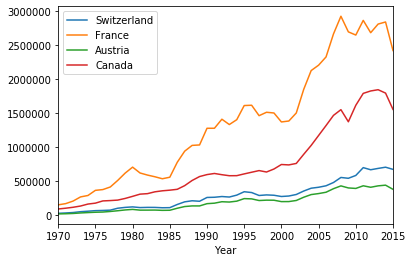

In [12]:
select_switzerland = df_useful["GDP"]['Area']=='Switzerland'
select_france = df_useful["GDP"]['Area']=='France'
select_austria = df_useful["GDP"]['Area']=='Austria'
select_canada = df_useful["GDP"]['Area']=='Canada'
ax = df_useful["GDP"][select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

For dissolute or new countries, we have some Nan values (before appearing or after dissolution) as in this next example :

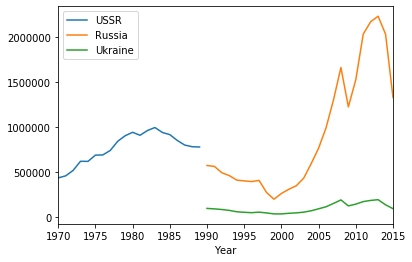

In [13]:
select_USSR = df_useful["GDP"]['Area']=='USSR'
select_russia = df_useful["GDP"]['Area']=='Russian Federation'
select_ukraine = df_useful["GDP"]['Area']=='Ukraine'
ax = df_useful["GDP"][select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.ii. Extracting crops harvested area, production, seed and yield from the "Crops production" dataset<a name="1Daii"></a>
We want to extract crops harvested area, production, seed and yield from the "Crops production" dataset. As all crops are not food crops, we request the [World crops database](https://world-crops.com/food-crops/) to keep only the food crops.

In [14]:
def get_food_crops():
    #Return a list of crops categorized as food crops https://world-crops.com/food-crops/
    url="https://world-crops.com/food-crops/"
    r=requests.get(url,headers={"User-Agent": "XY"})
    soup=BeautifulSoup(r.text,'html.parser')
    elements_temp=soup.find_all('a',href=re.compile("^../"))
    elements=[el.text for el in elements_temp]
    
    #only 40 elements are displayed on each page->iterating on the total list
    for i in range(40,401,40):
        url_i=url+"?ss="+str(i)
        r=requests.get(url_i,headers={"User-Agent":"XY"})
        soup=BeautifulSoup(r.text,'html.parser')
        new_elements=soup.find_all('a',href=re.compile("^../"))
        elements+=[el.text for el in new_elements]
    return elements

def inclusive_search(string,elements):
    #returns true if the string can be found in elements. The search removes special characters from string in order to include more positive results
    string=string.lower()
    delimiters = ",", "(","&",")"," and "," "
    pattern = '|'.join(map(re.escape, delimiters))
    strings=list(filter(None,re.split(pattern,string)))
    found=False
    for s in strings:
        if s=="nes":
            continue
        for el in elements:
            found=(s in el.split())
            if found==False and s[-1]=="s":
                found=s[:-1] in el.split()
            if found==False and s[-2:]=="es":
                found=s[:-2] in el.split()
            if found==False and s[-3:]=="ies":
                found=s[:-3]+"y" in el.split()
            if found==True:
                return found
    return found


def get_food_crop_data(df):    
    #extracts the food crop data, returns 4 df: Area,Production,Seed and yield    
    df=df.copy()
    food_crops=list(map(lambda x: x.lower(),get_food_crops()))              
    crop_types_df=df[['Item','Value']].groupby('Item').sum()
    crop_types_df=crop_types_df[list(map(lambda x : inclusive_search(x,food_crops) , crop_types_df.index ))]   
    food_crop_df=df[df.Item.apply(lambda x: x in crop_types_df.index)]
    return (food_crop_df[food_crop_df.Element=='Area harvested'],
            food_crop_df[food_crop_df.Element=='Production'],
            food_crop_df[food_crop_df.Element=='Seed'],
            food_crop_df[food_crop_df.Element=='Yield'])
  
food_crop_area_df , food_crop_production_df , food_crop_seed_df , food_crop_yield_df = get_food_crop_data(df["Crops production"])

In [15]:
df_useful['Crops Area harvested'] = food_crop_area_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Production'] = food_crop_production_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Seed'] = food_crop_seed_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Yield'] =  food_crop_yield_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

We check everything is fine by looking at samples for each of the new dataframes:

In [16]:
display(df_useful['Crops Area harvested'].sample(5))
display(df_useful['Crops Production'].sample(5))
display(df_useful['Crops Seed'].sample(5))
display(df_useful['Crops Yield'].sample(5))

Area Code                              Area                    Item  \
239460         233                      Burkina Faso  Groundnuts, with shell   
650881          75                            Gambia        Fruit, fresh nes   
1273423        165                          Pakistan  Eggplants (aubergines)   
189234          19  Bolivia (Plurinational State of)  Roots and Tubers,Total   
1782981        231          United States of America              Sugar beet   

         Year Unit     Value  
239460   1967   ha  142000.0  
650881   1979   ha       NaN  
1273423  1998   ha    8190.0  
189234   1965   ha  143045.0  
1782981  2014   ha  463900.0

Area Code                                     Area  \
838350         102               Iran (Islamic Republic of)   
2134669       5207                            South America   
2590771       5817  Net Food Importing Developing Countries   
2093460       5204                          Central America   
2215442       5303                            Southern Asia   

                            Item  Year    Unit       Value  
838350   Fruit excl Melons,Total  1998  tonnes  11649383.0  
2134669               Kiwi fruit  1992  tonnes     85000.0  
2590771               Sugar beet  1976  tonnes   2808357.0  
2093460         Lemons and limes  1994  tonnes   1001782.0  
2215442                Buckwheat  1969  tonnes      3800.0

Area Code           Area                       Item  Year    Unit  \
716212          88           Guam                      Maize  2009  tonnes   
2122478       5206      Caribbean  Cereals (Rice Milled Eqv)  1965  tonnes   
2296236       5400         Europe                        Rye  1981  tonnes   
636953          69  French Guiana  Cereals (Rice Milled Eqv)  1987  tonnes   
555985          59          Egypt              Cow peas, dry  2014  tonnes   

             Value  
716212         0.0  
2122478    28032.0  
2296236  2630157.0  
636953       236.0  
555985       135.0

Area Code          Area                          Item  Year   Unit  \
108403          12       Bahamas            Citrus Fruit,Total  1997  hg/ha   
595975          62  Ethiopia PDR                        Millet  1972  hg/ha   
1187783        150   Netherlands                        Grapes  1971  hg/ha   
99865           52    Azerbaijan                      Currants  2009  hg/ha   
387895          44      Colombia  Cabbages and other brassicas  1976  hg/ha   

            Value  
108403   207086.0  
595975     5163.0  
1187783  279739.0  
99865     35000.0  
387895   381809.0

We also make some plots to have a first understanding of the dataset:

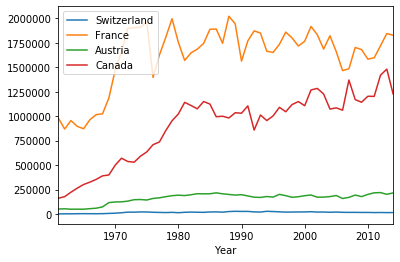

In [17]:
select_Maize = df_useful['Crops Area harvested']['Item']=='Maize'
maize_df = df_useful['Crops Area harvested'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

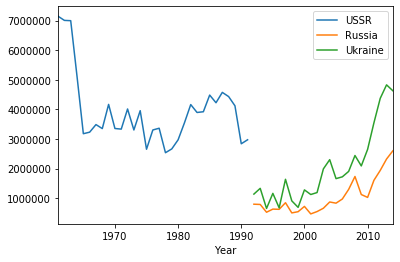

In [18]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.iii. Extracting stocks production from the "Livestock production" dataset<a name="1Daiii"></a>

We want to extract stocks production from the "Livestock production" dataset. Again, we drop the columns that are useless for us and have a first look of the data with a sample and some plots.

In [19]:
selection_stocks = df['Livestock production']["Element"] == 'Stocks'
df_useful['Livestock production'] = df['Livestock production'][selection_stocks].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [20]:
display(df_useful['Livestock production'].sample(5))

Area Code            Area      Item  Year       Unit      Value
56414         101       Indonesia    Cattle  1961       Head  6356000.0
17975          29         Burundi  Beehives  1972         No    85000.0
114518        176     Timor-Leste     Goats  1987       Head    79053.0
32736          51  Czechoslovakia   Turkeys  1989  1000 Head     1140.0
72197         134           Malta  Chickens  1963  1000 Head      520.0

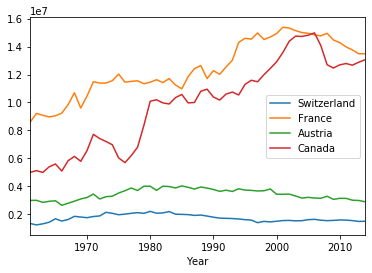

In [21]:
select_pigs = df_useful['Livestock production']['Item']=='Pigs'
pigs_df = df_useful['Livestock production'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

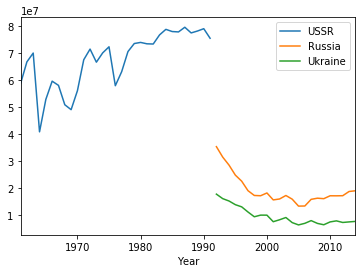

In [22]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.iv. Extracting import and export quantities from the "Live animals trade" and "Crops trade" datasets<a name="1Daiv"></a>
Now, we extract import and export quantities from the "Live animals trade" and "Crops trade" datasets, having again some samples and some plots.

In [23]:
selection_import_quantities = df['Live animals trade']["Element"] == 'Import Quantity'
selection_export_quantities = df['Live animals trade']["Element"] == 'Export Quantity'

df_useful['Live animals import quantities'] = df['Live animals trade'][selection_import_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Live animals export quantities'] = df['Live animals trade'][selection_export_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [24]:
display(df_useful['Live animals import quantities'].sample(5))

Area Code                    Area             Item  Year  Unit  \
410410        197            Sierra Leone           Cattle  1990  Head   
336713        159                 Nigeria  Bovine, Animals  2010  Head   
569777       5206               Caribbean            Goats  1975  Head   
16066           9               Argentina  Sheep and Goats  1968  Head   
63421         239  British Virgin Islands           Horses  1995  Head   

           Value  
410410   25000.0  
336713  450000.0  
569777    1611.0  
16066      151.0  
63421        0.0

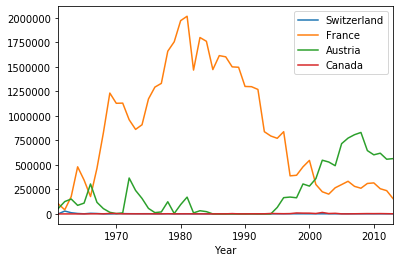

In [25]:
select_pigs = df_useful['Live animals import quantities']['Item']=='Pigs'
pigs_df = df_useful['Live animals import quantities'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

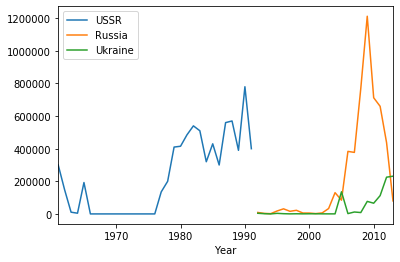

In [26]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In [27]:
display(df_useful['Live animals export quantities'].sample(5))

Area Code             Area                  Item  Year       Unit  \
608999       5402  Northern Europe  Pigeons, other birds  2003  1000 Head   
151904         58          Ecuador     Rabbits and hares  1969  1000 Head   
206555         91           Guyana                 Goats  1961       Head   
58110          20         Botswana                Horses  1984       Head   
369893        174         Portugal                 Ducks  1993  1000 Head   

        Value  
608999    1.0  
151904    NaN  
206555    NaN  
58110     6.0  
369893    NaN

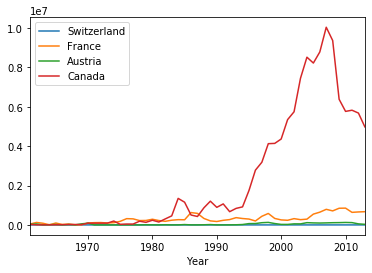

In [28]:
select_pigs = df_useful['Live animals export quantities']['Item']=='Pigs'
pigs_df = df_useful['Live animals export quantities'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

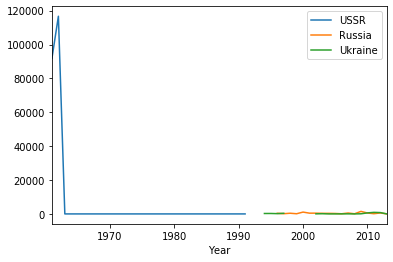

In [29]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In [30]:
selection_import_quantities = df['Food trade']["Element"] == 'Import Quantity'
selection_export_quantities = df['Food trade']["Element"] == 'Export Quantity'

df_useful['Food import quantities'] = df['Food trade'][selection_import_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Food export quantities'] = df['Food trade'][selection_export_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [31]:
display(df_useful['Food import quantities'].sample(5))

Area Code     Area                Item  Year    Unit   Value
2131007          40    Chile             Tobacco  1980  tonnes  3736.0
11770888       5000    World  Hair, goat, coarse  1974  tonnes    25.0
1028816          23   Belize          Soya sauce  1988  tonnes     0.0
7509061         159  Nigeria            Silk raw  1999  tonnes    25.0
6931094          28  Myanmar              Butter  1984  tonnes     0.0

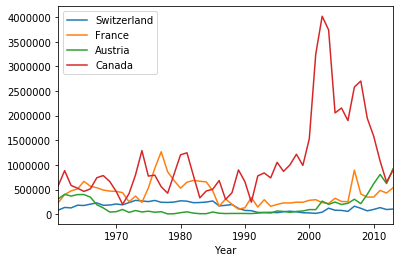

In [32]:
select_Maize = df_useful['Food import quantities']['Item']=='Maize'
maize_df = df_useful['Food import quantities'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

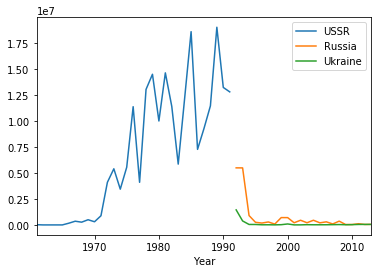

In [33]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In [34]:
display(df_useful['Food export quantities'].sample(5))

Area Code        Area                             Item  Year  \
13951988       5503  Micronesia             Tobacco products nes  1963   
3169474          54     Denmark         Meat, beef, preparations  1989   
13263643       5400      Europe  Fat, liver prepared (foie gras)  1985   
9799241         209   Swaziland                           Tallow  2011   
10580451        226      Uganda              Groundnuts, shelled  1977   

            Unit    Value  
13951988  tonnes      0.0  
3169474   tonnes  10909.0  
13263643  tonnes    986.0  
9799241   tonnes      0.0  
10580451  tonnes      NaN

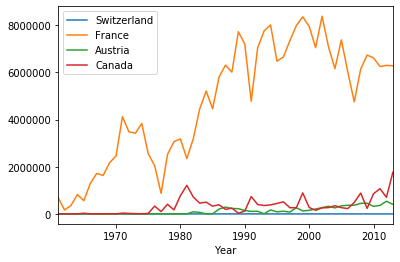

In [35]:
select_Maize = df_useful['Food export quantities']['Item']=='Maize'
maize_df = df_useful['Food export quantities'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

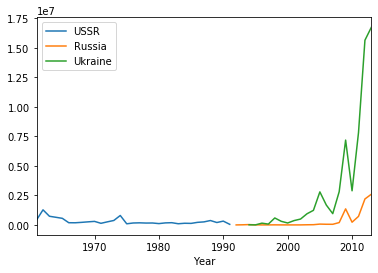

In [36]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.v. Extracting average CPI of each year from the "Consumer price indices" dataset<a name="1Dav"></a>

The "Consumer price indices" dataset contains monthly data. In order to have a uniform dataframe, and as other dataframes have yearly data, we group it by (Country, Year) and compute the mean over the monthes.

In [37]:
df_useful['Consumer price indices'] =  df['Consumer price indices'][['Area',"Year",'Value']] \
                                        .dropna() \
                                        .groupby(['Area',"Year"]) \
                                        .mean() \
                                        .reset_index() \
                                        .dropna()

With samples and plots, we remark that this dataset only start in 2000 wheareas other ones start in 1970.

In [38]:
display(df_useful['Consumer price indices'].sample(5))

Area  Year       Value
1181               Germany  2012  105.196005
102    Antigua and Barbuda  2013  108.083497
3183  United Arab Emirates  2015  105.291384
1552                Jordan  2003   69.642768
2824           South Sudan  2007   67.573301

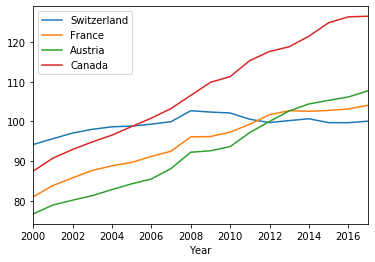

In [39]:
select_switzerland = df_useful['Consumer price indices']['Area']=='Switzerland'
select_france = df_useful['Consumer price indices']['Area']=='France'
select_austria = df_useful['Consumer price indices']['Area']=='Austria'
select_canada = df_useful['Consumer price indices']['Area']=='Canada'
ax = df_useful['Consumer price indices'][select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful['Consumer price indices'][select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful['Consumer price indices'][select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful['Consumer price indices'][select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

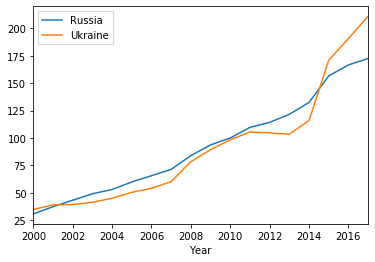

In [40]:
select_russia = df_useful["Consumer price indices"]['Area']=='Russian Federation'
select_ukraine = df_useful["Consumer price indices"]['Area']=='Ukraine'
ax = df_useful["Consumer price indices"][select_russia].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["Consumer price indices"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(['Russia', 'Ukraine'])

##### 1.D.a.vi. Removing areas which are not countries <a name="1Davi"></a>

Having a more detailled look at the dataset, we have remarked that the areas which are real countries are exactely the ones with an "Area Code" below $5000$ but not in $[261, 269]$.

In [41]:
#remove Area code >= 5000 or in [261, 269] (EU)
for df_name in df_useful :
    if 'Area Code' in df_useful[df_name].keys() : 
        print ("Removing areas which are not countries in", df_name)
        selection_countries = df_useful[df_name]['Area Code']<261 
        selection_countries = selection_countries | df_useful[df_name]['Area Code']>269
        selection_countries = selection_countries & df_useful[df_name]['Area Code']<5000
        df_useful[df_name] = df_useful[df_name][selection_countries]
        display(df_useful[df_name].sample(5))
    else :
        print (df_name, "is already clean")

Removing areas which are not countries in GDP


Area Code                                   Area  Year          Value
263508        122                                Lesotho  2013    2218.112442
61266          20                               Botswana  1976     296.963130
130350        167                                Czechia  2006  155213.120560
391135        185                     Russian Federation  1979            NaN
134059        116  Democratic People's Republic of Korea  1978    9116.107415

Removing areas which are not countries in Crops Area harvested


Area Code         Area                    Item  Year Unit     Value
860686         105       Israel            Beans, green  2011   ha     950.0
2197             2  Afghanistan                   Maize  2012   ha  141000.0
1789729        234      Uruguay        Fruit, fresh nes  1969   ha       NaN
956114         118       Kuwait  Eggplants (aubergines)  1980   ha       9.0
303596          39         Chad                   Maize  1974   ha    5600.0

Removing areas which are not countries in Crops Production


Area Code               Area                      Item  Year    Unit  \
2458097       5706     European Union    Peaches and nectarines  1967  tonnes   
237654          27           Bulgaria  Vegetables&Melons, Total  1965  tonnes   
579527          61  Equatorial Guinea             Coffee, green  2009  tonnes   
1088813        137          Mauritius                  Coconuts  2001  tonnes   
902168         109            Jamaica    Roots and Tubers,Total  2014  tonnes   

             Value  
2458097  2194704.0  
237654   1658513.0  
579527      4000.0  
1088813     1500.0  
902168    235063.0

Removing areas which are not countries in Crops Seed


Area Code                       Area                           Item  \
1517959         25            Solomon Islands                    Rice, paddy   
1083248        136                 Mauritania                          Maize   
2478729       5801  Least Developed Countries                        Lentils   
1560327        203                      Spain                          Wheat   
861137         105                     Israel  Broad beans, horse beans, dry   

         Year    Unit     Value  
1517959  1966  tonnes      13.0  
1083248  1994  tonnes     149.0  
2478729  1973  tonnes   12783.0  
1560327  1976  tonnes  395000.0  
861137   2012  tonnes     832.0

Removing areas which are not countries in Crops Yield


Area Code            Area                          Item  Year   Unit  \
2452076       5706  European Union     Fruit, tropical fresh nes  1971  hg/ha   
1915161       5100          Africa                      Apricots  2009  hg/ha   
203740          21          Brazil                        Grapes  2002  hg/ha   
2268792       5305    Western Asia                       Oranges  2012  hg/ha   
756059          93           Haiti  Cabbages and other brassicas  1999  hg/ha   

            Value  
2452076  153875.0  
1915161   79342.0  
203740   173250.0  
2268792  194987.0  
756059    60502.0

Removing areas which are not countries in Livestock production


Area Code                Area           Item  Year       Unit  \
56872         101           Indonesia  Poultry Birds  1987  1000 Head   
14845          21              Brazil       Chickens  2013  1000 Head   
51425         175       Guinea-Bissau          Asses  1975       Head   
35964          56  Dominican Republic  Poultry Birds  2014  1000 Head   
145901       5305        Western Asia         Camels  1990       Head   

            Value  
56872    452581.0  
14845   1246638.0  
51425      2000.0  
35964    168000.0  
145901   957545.0

Removing areas which are not countries in Live animals import quantities


Area Code                              Area             Item  Year  \
52953          19  Bolivia (Plurinational State of)            Asses  1973   
585756       5302                      Eastern Asia            Sheep  1980   
317881        150                       Netherlands            Asses  1977   
302343        141                          Mongolia  Sheep and Goats  1965   
361916        171                       Philippines         Beehives  1966   

        Unit   Value  
52953   Head     0.0  
585756  Head  1485.0  
317881  Head     0.0  
302343  Head     0.0  
361916    No     NaN

Removing areas which are not countries in Live animals export quantities


Area Code                Area              Item  Year       Unit  \
506376        249               Yemen            Horses  1961       Head   
593086       5304  South-Eastern Asia             Ducks  1996  1000 Head   
378167        117   Republic of Korea             Sheep  1999       Head   
406474        195             Senegal           Turkeys  1997  1000 Head   
551116       5105      Western Africa  Animals live nes  1970       Head   

         Value  
506376     0.0  
593086  9006.0  
378167     NaN  
406474     NaN  
551116     0.0

Removing areas which are not countries in Food import quantities


Area Code              Area                  Item  Year    Unit  \
3945052          70  French Polynesia             Buckwheat  2010  tonnes   
13423996       5402   Northern Europe               Beeswax  2001  tonnes   
6286540         131          Malaysia           Cotton lint  1999  tonnes   
3042932         167           Czechia                Wafers  1993  tonnes   
7133768         150       Netherlands  Manila fibre (abaca)  1986  tonnes   

            Value  
3945052       0.0  
13423996    755.0  
6286540   83603.0  
3042932       NaN  
7133768     203.0

Removing areas which are not countries in Food export quantities


Area Code              Area                                    Item  \
2106432          40             Chile  Rice - total  (Rice milled equivalent)   
5522911         110             Japan                         Plums and sloes   
7181985         150       Netherlands                      Wine+Vermouth+Sim.   
5375210         106             Italy                       Pineapples canned   
12488913       5203  Northern America            Sweet corn prep or preserved   

          Year    Unit     Value  
2106432   1997  tonnes       5.0  
5522911   1964  tonnes       0.0  
7181985   1973  tonnes    7676.0  
5375210   1974  tonnes     148.0  
12488913  2009  tonnes  123018.0

Consumer price indices is already clean


#### 1.D.b. Handling of the missing data  <a name="1Db"></a>

In this section, we will explain how we will handle the missing data in previous dataframes for maps.

##### 1.D.b.i. Highlighting the problem  <a name="1Dbi"></a> 

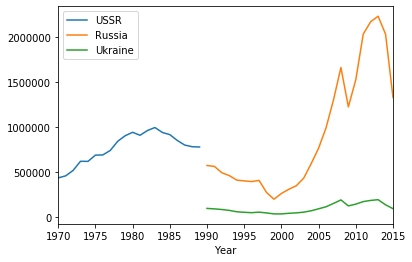

In [42]:
select_USSR = df_useful["GDP"]['Area']=='USSR'
select_russia = df_useful["GDP"]['Area']=='Russian Federation'
select_ukraine = df_useful["GDP"]['Area']=='Ukraine'
ax = df_useful["GDP"][select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In order to vizualize folium maps, we need to associate each country a value. The geojson file that we use is not timestamped and only countries that exist nowadays are inside it. As some countries has been dissolved during the past 50 years, our folium maps won't be complete. For instance, we do not have any value for Ukraine from 1970 to 1989. Our idea to fix this issue is presented in the next paragraph.

##### 1.D.b.ii. Proposed correction  <a name="1Dbii"></a> 


Our idea is to map the former country value to each of the current ones. For instance in 1982, USSR GDP is around one trillion $. Therefore, if we associate (only for folium map purposes) this value to each current country that succeeded USSR, all these countries will appear the same color in the folium map, i.e. all the USSR area will appear the same color (and the good one).

In order to do so, one need to identify which countries appeared and disappeared from the dataset and at which year. Then we will use this result along with some historical research in our `visualise_world_data_folium` function ([1Ea](#1Ea)).

In [43]:
countries_formation_years = {}
for country in df_useful["GDP"]["Area"].unique():
    selection = df_useful["GDP"]["Area"] == country
    year_in, year_out = df_useful["GDP"][selection].dropna()["Year"].min(), df_useful["GDP"][selection].dropna()["Year"].max()
    for year in (year_in, year_out):
        if year not in countries_formation_years :
            countries_formation_years[year] = []
    countries_formation_years[year_in].append((country,'+'))
    countries_formation_years[year_out].append((country,'-'))

countries_formation_years.pop(1970)
countries_formation_years.pop(2015)
for year in sorted(list(countries_formation_years)):
    print (year, countries_formation_years[year])

1988 [('Yemen Ar Rp', '-'), ('Yemen Dem', '-')]
1989 [('Czechoslovakia', '-'), ('Ethiopia PDR', '-'), ('USSR', '-'), ('Yemen', '+'), ('Yugoslav SFR', '-')]
1990 [('Armenia', '+'), ('Azerbaijan', '+'), ('Belarus', '+'), ('Bosnia and Herzegovina', '+'), ('Croatia', '+'), ('Czechia', '+'), ('Eritrea', '+'), ('Estonia', '+'), ('Ethiopia', '+'), ('Georgia', '+'), ('Kazakhstan', '+'), ('Kyrgyzstan', '+'), ('Latvia', '+'), ('Lithuania', '+'), ('Montenegro', '+'), ('Republic of Moldova', '+'), ('Russian Federation', '+'), ('Serbia', '+'), ('Slovakia', '+'), ('Slovenia', '+'), ('Tajikistan', '+'), ('The former Yugoslav Republic of Macedonia', '+'), ('Timor-Leste', '+'), ('Turkmenistan', '+'), ('Ukraine', '+'), ('Uzbekistan', '+'), ('Central Asia', '+')]
1999 [('Kosovo', '+')]
2005 [('Curaçao', '+'), ('Sint Maarten (Dutch Part)', '+')]
2007 [('Sudan (former)', '-')]
2008 [('South Sudan', '+'), ('Sudan', '+')]
2012 [('Netherlands Antilles (former)', '-')]


### 1.E. Preprocessing the data set  <a name="1E"></a>

In this part, we will finish prepocessing the datasets. More precisely, we will deal with country names and normalizing the features.

#### 1.E.a. Converting country names between different naming conventions  <a name="1Ea"></a>
Some countries have different names in the geojson file and in the dataset. We first start by correcting them.

In [44]:
dic = {'Czechia': "Czech Republic",
       'Russian Federation':'Russia',
       "Serbia":"Republic of Serbia",
       'The former Yugoslav Republic of Macedonia':'Macedonia',
       'China, mainland':'China',
       'Viet Nam':'Vietnam',
       'Venezuela (Bolivarian Republic of)':'Venezuela',
       'Iran (Islamic Republic of)':'Iran',
       'Syrian Arab Republic':"Syria",
       'Bolivia (Plurinational State of)': 'Bolivia',
       "Côte d'Ivoire": "Ivory Coast",
       'Congo':"Republic of the Congo",
       "Lao People's Democratic Republic":'Laos',
       "Democratic People's Republic of Korea":"North Korea",
       'Republic of Korea':"South Korea"}

def correct_country_names(old_name):
    if old_name in dic.keys() :
        return dic[old_name]
    return old_name


In [45]:
for df_name in df_useful :
    print (df_name)
    df_useful[df_name]["Area"] = df_useful[df_name]["Area"].apply(correct_country_names)

GDP
Crops Area harvested
Crops Production
Crops Seed
Crops Yield
Livestock production
Live animals import quantities
Live animals export quantities
Food import quantities
Food export quantities
Consumer price indices


Then, we do a function that takes as input a dataframe and a year and produces the corresponding folium map. This function also handles dissolutions of countries as suggested [before](#1Dbii).

In [46]:
def visualise_world_data_folium(df, year, logScale=True):
    dic = {'USSR':                            ['Armenia', 'Azerbaijan','Belarus', 'Estonia', 'Georgia',
                                               'Kazakhstan', 'Kyrgyzstan', 'Latvia', 'Lithuania',
                                               'Montenegro', 'Republic of Moldova', 'Russia',
                                               'Republic of Serbia', 'Timor-Leste', 'Turkmenistan', 'Ukraine',
                                               'Uzbekistan'],
           'Ethiopia PDR':                     ['Eritrea','Ethiopia'],
           'Yugoslav SFR':                     ['Kosovo', 'Slovenia', 'Croatia',
                                                'Macedonia', 'Bosnia and Herzegovina'],
           'Yemen Dem' :                       ['Yemen'],        
           'Czechoslovakia':                   ["Czech Republic", 'Slovakia'],
           'Netherlands Antilles (former)':    ['Curaçao', 'Sint Maarten (Dutch Part)'],
           'Sudan (former)':                   ['South Sudan', 'Sudan']
          }
    def add_new_names(old_name):
        if old_name in dic.keys() :
            return dic[old_name]
        return old_name
    to_plot=df[df["Year"]==year]
    to_plot=(to_plot[['Area','Value']]
             .dropna()
             .groupby('Area')             
             .mean()
             .reset_index()
             .dropna())    
    to_plot['Area']=to_plot['Area'].apply(add_new_names)
    to_plot = to_plot.explode('Area')
    if logScale :
        to_plot.Value=np.log10(to_plot.Value)
    
    m = folium.Map(location=[40,-10],zoom_start=1.6)
    folium.Choropleth(
        geo_data=f"https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json",
        data=to_plot,
        columns=['Area', 'Value'],
        key_on='feature.properties.name',
        fill_color='YlGn',fill_opacity=0.7,line_opacity=0.2,nan_fill_opacity=0.0
    ).add_to(m)

    folium.LayerControl().add_to(m)

    return(m)

We can know use it to produce some maps. For instance, we plot below the map of GDP for the year 1985 (befor edissolution of USSR).

In [47]:
display(visualise_world_data_folium(df_useful["GDP"], 1985, True))

#### 1.E.b. Normalization and log scales  <a name="1Eb"></a>

Some of our features seem to be right skewed. At first glance it seems that they look like power laws.

For instance the distribution of GDP look a bit like a power law:

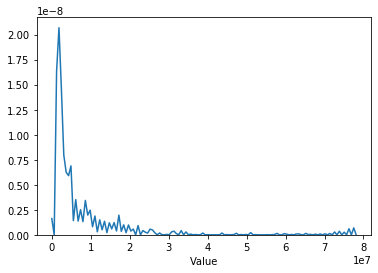

In [48]:
sns.distplot(df_useful["GDP"]["Value"], rug=False, hist=False)

As we later want to train some Machine Learning models, we log those values so that their distribution look a bit more like a normal distribution.

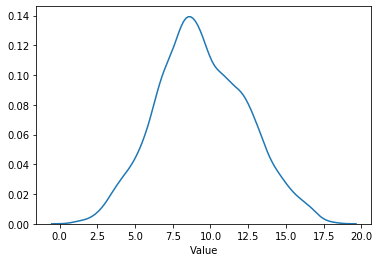

In [49]:
#looks better with log scale
sns.distplot(np.log(df_useful["GDP"]["Value"]), rug=False, hist=False)

The new distribution indeed looks better to train models on it.

### 1.F. Making one uniformized dataframe  <a name="1F"></a>

In this part, we will make one uniformized dataframe `uni_df` with the following columns.


    Country | Year | GDP | Crops production columns | Livestock production columns | Crops importation columns | Livestock importation columns | Crops exportation columns | Livestock exportation columns | CPI
    
In this uniformized dataframe, a tuple `(Country, Year)` uniquely identifies a row.


#### 1.F.a. Pivoting dataframes with items  <a name="1Fa"></a>

The current dataframes have several rows for a given `(Country, Year)`. Each of this row correspond to one item. We would like to have a unique row for a given `(Country, Year)` and one column per item:

In [50]:
need_pivot = ['Crops Area harvested',
              'Crops Production',
              'Crops Seed',
              'Crops Yield',
              'Livestock production',
              'Live animals import quantities',
              'Live animals export quantities',
              'Food import quantities',
              'Food export quantities']

def rename_columns(x, word):
    if x not in ['Area', 'Year', 'ha', 'tonnes', 'hg/ha', 'Head', '1000 Head']:
        return x + ' ' + word
    return x

df_useful['GDP'] = df_useful['GDP'].rename(columns = {'Value':'(GDP, million $)'})[["Area",'Year','(GDP, million $)']]
df_useful['Consumer price indices'] = df_useful['Consumer price indices'].rename(columns = {'Value':'(Consumer price indices, %)'})[["Area",'Year','(Consumer price indices, %)']]

for df_name in need_pivot :
    df_useful[df_name] = pd.pivot_table(df_useful[df_name], index=["Area",'Year'], columns=["Item","Unit"], values="Value").rename(columns=lambda x: rename_columns(x, df_name))
    display(df_useful[df_name].sample(5))

Item                                  Anise, badian, fennel, coriander Crops Area harvested  \
Unit                                                                                     ha   
Area                             Year                                                         
Suriname                         1998                                                NaN      
Micronesia (Federated States of) 1995                                                NaN      
Dominican Republic               1972                                                NaN      
Botswana                         1998                                                NaN      
Western Asia                     1991                                            22738.0      

Item                                  Apples Crops Area harvested  \
Unit                                                           ha   
Area                             Year                               
Suriname                         1998                         NaN   
Micronesia (Federated States of) 1995                         NaN   
Dominican Republic               1972                         NaN   
Botswana                         1998                         NaN   
Western Asia                     1991                    158320.0   

Item                                  Apricots Crops Area harvested  \
Unit                                                             ha   
Area                             Year                                 
Suriname                         1998                           NaN   
Micronesia (Federated States of) 1995                           NaN   
Dominican Republic               1972                           NaN   
Botswana                         1998                           NaN   
Western Asia                     1991                       70627.0   

Item                                  Areca nuts Crops Area harvested  \
Unit                                                               ha   
Area                             Year                                   
Suriname                         1998                             NaN   
Micronesia (Federated States of) 1995                             NaN   
Dominican Republic               1972                             NaN   
Botswana                         1998                             NaN   
Western Asia                     1991                             NaN   

Item                                  Artichokes Crops Area harvested  \
Unit                                                               ha   
Area                             Year                                   
Suriname                         1998                             NaN   
Micronesia (Federated States of) 1995                             NaN   
Dominican Republic               1972                             NaN   
Botswana                         1998                             NaN   
Western Asia                     1991                          2354.0   

Item                                  Asparagus Crops Area harvested  \
Unit                                                              ha   
Area                             Year                                  
Suriname                         1998                            NaN   
Micronesia (Federated States of) 1995                            NaN   
Dominican Republic               1972                            NaN   
Botswana                         1998                            NaN   
Western Asia                     1991                           49.0   

Item                                  Avocados Crops Area harvested  \
Unit                                                             ha   
Area                             Year                                 
Suriname                         1998                           NaN   
Micronesia (Federated States of) 1995                           NaN   
Dominican Repub

Item            Anise, badian, fennel, coriander Crops Production  \
Unit                                                       tonnes   
Area       Year                                                     
Bolivia    1967                                               NaN   
Montserrat 1970                                               NaN   
Niue       1962                                               NaN   
Cameroon   2013                                               NaN   
Malaysia   2012                                               NaN   

Item            Apples Crops Production Apricots Crops Production  \
Unit                             tonnes                    tonnes   
Area       Year                                                     
Bolivia    1967                 17200.0                       NaN   
Montserrat 1970                     NaN                       NaN   
Niue       1962                     NaN                       NaN   
Cameroon   2013                     NaN                     854.0   
Malaysia   2012                     NaN                       NaN   

Item            Areca nuts Crops Production Artichokes Crops Production  \
Unit                                 tonnes                      tonnes   
Area       Year                                                           
Bolivia    1967                         NaN                         NaN   
Montserrat 1970                         NaN                         NaN   
Niue       1962                         NaN                         NaN   
Cameroon   2013                         NaN                         NaN   
Malaysia   2012                       338.0                         NaN   

Item            Asparagus Crops Production Avocados Crops Production  \
Unit                                tonnes                    tonnes   
Area       Year                                                        
Bolivia    1967                        NaN                    1830.0   
Montserrat 1970                        NaN                       NaN   
Niue       1962                        NaN                       NaN   
Cameroon   2013                        NaN                   71776.0   
Malaysia   2012                        NaN                       NaN   

Item            Bambara beans Crops Production Bananas Crops Production  \
Unit                                    tonnes                   tonnes   
Area       Year                                                           
Bolivia    1967                            NaN                 182500.0   
Montserrat 1970                            NaN                    120.0   
Niue       1962                            NaN                    150.0   
Cameroon   2013                        36639.0                1600231.0   
Malaysia   2012                            NaN                 289034.0   

Item            Barley Crops Production  ... Sweet potatoes Crops Production  \
Unit                             tonnes  ...                          tonnes   
Area       Year                          ...                                   
Bolivia    1967                 56000.0  ...                         11100.0   
Montserrat 1970                     NaN  ...                             7.0   
Niue       1962                     NaN  ...                           380.0   
Cameroon   2013                     NaN  ...                        348618.0   
Malaysia   2012                     NaN  ...                         55838.0   

Item            Tangerines, mandarins, clementines, satsumas Crops Production  \
Unit                                                                   tonnes   
Area       Year                                                                 
Bolivia    1967                                            17000.0              
Montserrat 1970                                                NaN              
Niue       1962                                                NaN   

Item              Anise, badian, fennel, coriander Crops Seed  \
Unit                                                   tonnes   
Area         Year                                               
Asia         2002                                         4.0   
Niger        1981                                         NaN   
Polynesia    2013                                         NaN   
Burkina Faso 1979                                         NaN   
Cyprus       1975                                         NaN   

Item              Bambara beans Crops Seed Bananas Crops Seed  \
Unit                                tonnes             tonnes   
Area         Year                                               
Asia         2002                      NaN                NaN   
Niger        1981                      0.0                NaN   
Polynesia    2013                      NaN                NaN   
Burkina Faso 1979                    360.0                NaN   
Cyprus       1975                      NaN                NaN   

Item              Barley Crops Seed Beans, dry Crops Seed  \
Unit                         tonnes                tonnes   
Area         Year                                           
Asia         2002         1606031.0              591634.0   
Niger        1981               NaN                   0.0   
Polynesia    2013               NaN                   NaN   
Burkina Faso 1979               NaN                   NaN   
Cyprus       1975            5966.0                  46.0   

Item              Broad beans, horse beans, dry Crops Seed  \
Unit                                                tonnes   
Area         Year                                            
Asia         2002                                 130678.0   
Niger        1981                                      NaN   
Polynesia    2013                                      NaN   
Burkina Faso 1979                                      NaN   
Cyprus       1975                                    279.0   

Item              Buckwheat Crops Seed  \
Unit                            tonnes   
Area         Year                        
Asia         2002              90718.0   
Niger        1981                  NaN   
Polynesia    2013                  NaN   
Burkina Faso 1979                  NaN   
Cyprus       1975                  NaN   

Item              Cabbages and other brassicas Crops Seed  \
Unit                                               tonnes   
Area         Year                                           
Asia         2002                                     NaN   
Niger        1981                                     NaN   
Polynesia    2013                                     NaN   
Burkina Faso 1979                                     NaN   
Cyprus       1975                                     NaN   

Item              Carrots and turnips Crops Seed Cassava Crops Seed  ...  \
Unit                                      tonnes             tonnes  ...   
Area         Year                                                    ...   
Asia         2002                            NaN                NaN  ...   
Niger        1981                            NaN                NaN  ...   
Polynesia    2013                            NaN                NaN  ...   
Burkina Faso 1979                            NaN                NaN  ...   
Cyprus       1975                            NaN                NaN  ...   

Item              Sorghum Crops Seed Soybeans Crops Seed  \
Unit                          tonnes              tonnes   
Area         Year                                          
Asia         2002           333309.0           1481863.0   
Niger        1981            22692.0                 NaN   
Polynesia    2013                NaN                 NaN   
Burkina Faso 1979            17221.0                 0.0   
Cyprus       1975                NaN                 NaN   

Item              Sugar cane Crops Seed Sweet potatoes C

Item                           Anise, badian, fennel, coriander Crops Yield  \
Unit                                                                  hg/ha   
Area                      Year                                                
Vanuatu                   1966                                          NaN   
China                     2011                                      12147.0   
Central America           1994                                      74257.0   
Niger                     1962                                          NaN   
Least Developed Countries 1976                                     118571.0   

Item                           Apples Crops Yield Apricots Crops Yield  \
Unit                                        hg/ha                hg/ha   
Area                      Year                                           
Vanuatu                   1966                NaN                  NaN   
China                     2011           165269.0              37099.5   
Central America           1994            79997.0              33861.0   
Niger                     1962                NaN                  NaN   
Least Developed Countries 1976            51759.0              78756.0   

Item                           Areca nuts Crops Yield Artichokes Crops Yield  \
Unit                                            hg/ha                  hg/ha   
Area                      Year                                                 
Vanuatu                   1966                    NaN                    NaN   
China                     2011                28142.0                68182.0   
Central America           1994                    NaN                73462.0   
Niger                     1962                    NaN                    NaN   
Least Developed Countries 1976                 7290.0                    NaN   

Item                           Asparagus Crops Yield Avocados Crops Yield  \
Unit                                           hg/ha                hg/ha   
Area                      Year                                              
Vanuatu                   1966                   NaN                  NaN   
China                     2011               54923.5              65625.0   
Central America           1994               37113.0              87440.0   
Niger                     1962                   NaN                  NaN   
Least Developed Countries 1976                   NaN             185068.0   

Item                           Bambara beans Crops Yield Bananas Crops Yield  \
Unit                                               hg/ha               hg/ha   
Area                      Year                                                 
Vanuatu                   1966                       NaN            122222.0   
China                     2011                       NaN            268758.5   
Central America           1994                       NaN            343514.0   
Niger                     1962                       NaN                 NaN   
Least Developed Countries 1976                    7710.0             62172.0   

Item                           Barley Crops Yield  ...  \
Unit                                        hg/ha  ...   
Area                      Year                     ...   
Vanuatu                   1966                NaN  ...   
China                     2011            31996.0  ...   
Central America           1994            26377.0  ...   
Niger                     1962                NaN  ...   
Least Developed Countries 1976            10788.0  ...   

Item                           Sweet potatoes Crops Yield  \
Unit                                                hg/ha   
Area                      Year                              
Vanuatu                   1966                        NaN   
China                     2011                   216457.0   
Central America           1994                   176489.0   
Niger                     1962              

Item              Animals live nes Livestock production  \
Unit                                               Head   
Area         Year                                         
Albania      1980                                   NaN   
Paraguay     1965                                   NaN   
Cabo Verde   2013                                   NaN   
South Africa 1965                                   NaN   
Kenya        1998                                   NaN   

Item              Asses Livestock production Beehives Livestock production  \
Unit                                    Head       No Livestock production   
Area         Year                                                            
Albania      1980                    80000.0                      110000.0   
Paraguay     1965                    21403.0                       69000.0   
Cabo Verde   2013                    15300.0                           NaN   
South Africa 1965                   330000.0                       48000.0   
Kenya        1998                        NaN                     2470000.0   

Item              Buffaloes Livestock production  \
Unit                                        Head   
Area         Year                                  
Albania      1980                         1700.0   
Paraguay     1965                            NaN   
Cabo Verde   2013                            NaN   
South Africa 1965                            NaN   
Kenya        1998                            NaN   

Item              Camelids, other Livestock production  \
Unit                                              Head   
Area         Year                                        
Albania      1980                                  NaN   
Paraguay     1965                                  NaN   
Cabo Verde   2013                                  NaN   
South Africa 1965                                  NaN   
Kenya        1998                                  NaN   

Item              Camels Livestock production Cattle Livestock production  \
Unit                                     Head                        Head   
Area         Year                                                           
Albania      1980                         NaN                    606000.0   
Paraguay     1965                         NaN                   4400000.0   
Cabo Verde   2013                         NaN                     22752.0   
South Africa 1965                         NaN                  12500000.0   
Kenya        1998                    799500.0                  11687000.0   

Item              Cattle and Buffaloes Livestock production  \
Unit                                                   Head   
Area         Year                                             
Albania      1980                                  607700.0   
Paraguay     1965                                 4400000.0   
Cabo Verde   2013                                   22752.0   
South Africa 1965                                12500000.0   
Kenya        1998                                11687000.0   

Item              Chickens Livestock production Ducks Livestock production  \
Unit                                  1000 Head                  1000 Head   
Area         Year                                                            
Albania      1980                        3492.0                        NaN   
Paraguay     1965                        6296.0                      261.0   
Cabo Verde   2013                        1117.0                        NaN   
South Africa 1965                       20500.0                      168.0   
Kenya        1998                       29718.0                        NaN   

Item               ... Horses Livestock production Mules Livestock production  \
Unit               ...                        Head                       Head   
Area         Year  ...                                                          
Albania      1980  ...        

Item              Animals live nes Live animals import quantities  \
Unit                                                         Head   
Area         Year                                                   
Kuwait       1986                                             NaN   
Saudi Arabia 2002                                             NaN   
Europe       2002                                             0.0   
Spain        1984                                             NaN   
Angola       1990                                             NaN   

Item              Asses Live animals import quantities  \
Unit                                              Head   
Area         Year                                        
Kuwait       1986                                  NaN   
Saudi Arabia 2002                                  0.0   
Europe       2002                               4832.0   
Spain        1984                                  0.0   
Angola       1990                                  NaN   

Item              Beehives Live animals import quantities  \
Unit                    No Live animals import quantities   
Area         Year                                           
Kuwait       1986                                     NaN   
Saudi Arabia 2002                                     NaN   
Europe       2002                                   387.0   
Spain        1984                                     NaN   
Angola       1990                                     NaN   

Item              Bovine, Animals Live animals import quantities  \
Unit                                                        Head   
Area         Year                                                  
Kuwait       1986                                         6435.0   
Saudi Arabia 2002                                        38869.0   
Europe       2002                                      3319935.0   
Spain        1984                                        35918.0   
Angola       1990                                            0.0   

Item              Buffaloes Live animals import quantities  \
Unit                                                  Head   
Area         Year                                            
Kuwait       1986                                      NaN   
Saudi Arabia 2002                                      NaN   
Europe       2002                                      0.0   
Spain        1984                                      NaN   
Angola       1990                                      NaN   

Item              Camelids, other Live animals import quantities  \
Unit                                                        Head   
Area         Year                                                  
Kuwait       1986                                            NaN   
Saudi Arabia 2002                                            NaN   
Europe       2002                                            NaN   
Spain        1984                                            NaN   
Angola       1990                                            NaN   

Item              Camels Live animals import quantities  \
Unit                                               Head   
Area         Year                                         
Kuwait       1986                                   0.0   
Saudi Arabia 2002                               20600.0   
Europe       2002                                   NaN   
Spain        1984                                   NaN   
Angola       1990                                   NaN   

Item              Cattle Live animals import quantities  \
Unit                                               Head   
Area         Year                                         
Kuwait       1986                                6435.0   
Saudi Arabia 2002                               38869.0   
Europe       2002                             3319935.0   
Spain        1984                               35918.0   
Angola       1990   

Item                       Animals live nes Live animals export quantities  \
Unit                                                                  Head   
Area                  Year                                                   
Burkina Faso          1963                                             NaN   
Algeria               1996                                             0.0   
Guinea                1978                                             NaN   
Cuba                  1987                                             NaN   
Saint Kitts and Nevis 1988                                             NaN   

Item                       Asses Live animals export quantities  \
Unit                                                       Head   
Area                  Year                                        
Burkina Faso          1963                                  NaN   
Algeria               1996                                  NaN   
Guinea                1978                                  NaN   
Cuba                  1987                                  NaN   
Saint Kitts and Nevis 1988                                  NaN   

Item                       Beehives Live animals export quantities  \
Unit                             No Live animals export quantities   
Area                  Year                                           
Burkina Faso          1963                                     NaN   
Algeria               1996                                     0.0   
Guinea                1978                                     NaN   
Cuba                  1987                                     NaN   
Saint Kitts and Nevis 1988                                     NaN   

Item                       Bovine, Animals Live animals export quantities  \
Unit                                                                 Head   
Area                  Year                                                  
Burkina Faso          1963                                       112234.0   
Algeria               1996                                            NaN   
Guinea                1978                                        30000.0   
Cuba                  1987                                          999.0   
Saint Kitts and Nevis 1988                                            0.0   

Item                       Buffaloes Live animals export quantities  \
Unit                                                           Head   
Area                  Year                                            
Burkina Faso          1963                                      NaN   
Algeria               1996                                      NaN   
Guinea                1978                                      NaN   
Cuba                  1987                                      NaN   
Saint Kitts and Nevis 1988                                      NaN   

Item                       Camelids, other Live animals export quantities  \
Unit                                                                 Head   
Area                  Year                                                  
Burkina Faso          1963                                            NaN   
Algeria               1996                                            NaN   
Guinea                1978                                            NaN   
Cuba                  1987                                            NaN   
Saint Kitts and Nevis 1988                                            NaN   

Item                       Camels Live animals export quantities  \
Unit                                                        Head   
Area                  Year                                         
Burkina Faso          1963                                   NaN   
Algeria               1996                                   NaN   
Guinea                1978                                   NaN   
Cuba                  1987                                   NaN  

Item          Alfalfa meal and pellets Food import quantities  \
Unit                                                   tonnes   
Area     Year                                                   
Gabon    2011                                             0.0   
Iran     1973                                             NaN   
Guam     1967                                             NaN   
Djibouti 2002                                             NaN   
Europe   2009                                        313921.0   

Item          Almonds shelled Food import quantities  \
Unit                                          tonnes   
Area     Year                                          
Gabon    2011                                    2.0   
Iran     1973                                    NaN   
Guam     1967                                    NaN   
Djibouti 2002                                    NaN   
Europe   2009                               317867.0   

Item          Animal Oil+Fat+Grs Food import quantities  \
Unit                                             tonnes   
Area     Year                                             
Gabon    2011                                      10.0   
Iran     1973                                   17991.0   
Guam     1967                                       NaN   
Djibouti 2002                                       0.0   
Europe   2009                                 1200215.0   

Item          Animal Vegetable Oil Food import quantities  \
Unit                                               tonnes   
Area     Year                                               
Gabon    2011                                     29015.0   
Iran     1973                                    133328.0   
Guam     1967                                         0.0   
Djibouti 2002                                     19068.0   
Europe   2009                                  23879075.0   

Item          Animal fats Food import quantities  \
Unit                                      tonnes   
Area     Year                                      
Gabon    2011                               10.0   
Iran     1973                            17991.0   
Guam     1967                                NaN   
Djibouti 2002                                0.0   
Europe   2009                          1200215.0   

Item          Anise, badian, fennel, coriander Food import quantities  \
Unit                                                           tonnes   
Area     Year                                                           
Gabon    2011                                                0.0        
Iran     1973                                               17.0        
Guam     1967                                                NaN        
Djibouti 2002                                               48.0        
Europe   2009                                            52652.0        

Item          Apples Food import quantities Apricots Food import quantities  \
Unit                                 tonnes                          tonnes   
Area     Year                                                                 
Gabon    2011                        2513.0                             0.0   
Iran     1973                        5758.0                             NaN   
Guam     1967                         362.0                             NaN   
Djibouti 2002                         144.0                             NaN   
Europe   2009                     4343799.0                        223886.0   

Item          Apricots, dry Food import quantities  \
Unit                                        tonnes   
Area     Year                                        
Gabon    2011                                  0.0   
Iran     1973                                  NaN   
Guam     1967                                  NaN   
Djibouti 2002                                  NaN   
Europe   2009                             103901.0   



Item                       Alfalfa meal and pellets Food export quantities  \
Unit                                                                tonnes   
Area                  Year                                                   
Niue                  2006                                             NaN   
Argentina             1986                                             0.0   
Singapore             1996                                          2303.0   
Sao Tome and Principe 1990                                             NaN   
Malaysia              2013                                            70.0   

Item                       Almonds shelled Food export quantities  \
Unit                                                       tonnes   
Area                  Year                                          
Niue                  2006                                    NaN   
Argentina             1986                                    0.0   
Singapore             1996                                  315.0   
Sao Tome and Principe 1990                                    NaN   
Malaysia              2013                                   71.0   

Item                       Animal Oil+Fat+Grs Food export quantities  \
Unit                                                          tonnes   
Area                  Year                                             
Niue                  2006                                       NaN   
Argentina             1986                                   27822.0   
Singapore             1996                                    1363.0   
Sao Tome and Principe 1990                                       NaN   
Malaysia              2013                                     243.0   

Item                       Animal Vegetable Oil Food export quantities  \
Unit                                                            tonnes   
Area                  Year                                               
Niue                  2006                                         0.0   
Argentina             1986                                   1929331.0   
Singapore             1996                                    468852.0   
Sao Tome and Principe 1990                                         0.0   
Malaysia              2013                                  20654632.0   

Item                       Animal fats Food export quantities  \
Unit                                                   tonnes   
Area                  Year                                      
Niue                  2006                                NaN   
Argentina             1986                            27822.0   
Singapore             1996                             1363.0   
Sao Tome and Principe 1990                                NaN   
Malaysia              2013                              243.0   

Item                       Anise, badian, fennel, coriander Food export quantities  \
Unit                                                                        tonnes   
Area                  Year                                                           
Niue                  2006                                                NaN        
Argentina             1986                                              220.0        
Singapore             1996                                            10772.0        
Sao Tome and Principe 1990                                                NaN        
Malaysia              2013                                              636.0        

Item                       Apples Food export quantities  \
Unit                                              tonnes   
Area                  Year                                 
Niue                  2006                           NaN   
Argentina             1986                      133859.0   
Singapore             1996                       18433.0   
Sao Tome and Principe 1990                           NaN   
Malaysia              

Some Nan values have appeared. As we have datasets that have great outliers, we would replace those Nan values by the median of the column:

In [51]:
# Deal with the NaN that appeared
for df_name in df_useful :
    for column in list(df_useful[df_name]):
        if column not in ['Area', 'Year']:
            df_useful[df_name][column].fillna(df_useful[df_name][column].median(), inplace=True)

In [52]:
#removing the multiindex, so that merge is clean with GDP and CPI
for df_name in need_pivot :
    df_useful[df_name].columns = [' '.join([str(_) for _ in v]) for v in df_useful[df_name].columns.values]
    display(df_useful[df_name].sample(5))
    

Anise, badian, fennel, coriander Crops Area harvested ha  \
Area                           Year                                                             
Occupied Palestinian Territory 1969                                             3100.0          
Israel                         2004                                             3100.0          
Peru                           2001                                             3100.0          
Panama                         1990                                             3100.0          
China, Macao SAR               1971                                             3100.0          

                                     Apples Crops Area harvested ha  \
Area                           Year                                   
Occupied Palestinian Territory 1969                         21040.0   
Israel                         2004                          4480.0   
Peru                           2001                         10601.0   
Panama                         1990                         21040.0   
China, Macao SAR               1971                         21040.0   

                                     Apricots Crops Area harvested ha  \
Area                           Year                                     
Occupied Palestinian Territory 1969                            5000.0   
Israel                         2004                            2300.0   
Peru                           2001                              45.0   
Panama                         1990                            5000.0   
China, Macao SAR               1971                            5000.0   

                                     Areca nuts Crops Area harvested ha  \
Area                           Year                                       
Occupied Palestinian Territory 1969                             49401.0   
Israel                         2004                             49401.0   
Peru                           2001                             49401.0   
Panama                         1990                             49401.0   
China, Macao SAR               1971                             49401.0   

                                     Artichokes Crops Area harvested ha  \
Area                           Year                                       
Occupied Palestinian Territory 1969                              2800.0   
Israel                         2004                               670.0   
Peru                           2001                               411.0   
Panama                         1990                              2800.0   
China, Macao SAR               1971                              2800.0   

                                     Asparagus Crops Area harvested ha  \
Area                           Year                                      
Occupied Palestinian Territory 1969                             2173.0   
Israel                         2004                               34.0   
Peru                           2001                            19038.0   
Panama                         1990                             2173.0   
China, Macao SAR               1971                             2173.0   

                                     Avocados Crops Area harvested ha  \
Area                           Year                                     
Occupied Palestinian Territory 1969                            2729.0   
Israel                         2004                            5100.0   
Peru                           2001                           10263.0   
Panama                         1990                             690.0   
China, Macao SAR               1971                            2729.0   

                                     Bambara beans Crops Area harvested ha  \
Area                           Year                                          
Occupied Palestinian Territory 1969                                35395.0   
Israel                        

Anise, badian, fennel, coriander Crops Production tonnes  \
Area                      Year                                                             
Asia                      1971                                            58640.0          
Malta                     1997                                             2686.0          
Sweden                    1988                                             2686.0          
Iceland                   1988                                             2686.0          
Wallis and Futuna Islands 1983                                             2686.0          

                                Apples Crops Production tonnes  \
Area                      Year                                   
Asia                      1971                       3854825.0   
Malta                     1997                           371.0   
Sweden                    1988                        130000.0   
Iceland                   1988                        240418.5   
Wallis and Futuna Islands 1983                        240418.5   

                                Apricots Crops Production tonnes  \
Area                      Year                                     
Asia                      1971                          304927.0   
Malta                     1997                           27679.0   
Sweden                    1988                           27679.0   
Iceland                   1988                           27679.0   
Wallis and Futuna Islands 1983                           27679.0   

                                Areca nuts Crops Production tonnes  \
Area                      Year                                       
Asia                      1971                            211648.0   
Malta                     1997                             30102.0   
Sweden                    1988                             30102.0   
Iceland                   1988                             30102.0   
Wallis and Futuna Islands 1983                             30102.0   

                                Artichokes Crops Production tonnes  \
Area                      Year                                       
Asia                      1971                             17579.0   
Malta                     1997                             21000.0   
Sweden                    1988                             21000.0   
Iceland                   1988                             21000.0   
Wallis and Futuna Islands 1983                             21000.0   

                                Asparagus Crops Production tonnes  \
Area                      Year                                      
Asia                      1971                           894532.0   
Malta                     1997                             7905.5   
Sweden                    1988                             7905.5   
Iceland                   1988                             7905.5   
Wallis and Futuna Islands 1983                             7905.5   

                                Avocados Crops Production tonnes  \
Area                      Year                                     
Asia                      1971                           50844.0   
Malta                     1997                           15422.5   
Sweden                    1988                           15422.5   
Iceland                   1988                           15422.5   
Wallis and Futuna Islands 1983                           15422.5   

                                Bambara beans Crops Production tonnes  \
Area                      Year                                          
Asia                      1971                                25100.0   
Malta                     1997                                25100.0   
Sweden                    1988                                25100.0   
Iceland                   1988                                25100.0   
Wallis and Futuna Islands 1983                                2510

Anise, badian, fennel, coriander Crops Seed tonnes  \
Area                     Year                                                       
Jordan                   1988                                                0.0    
Namibia                  1982                                                0.0    
Romania                  2008                                                0.0    
Central African Republic 1989                                                0.0    
Ecuador                  2006                                                0.0    

                               Bambara beans Crops Seed tonnes  \
Area                     Year                                    
Jordan                   1988                           1268.0   
Namibia                  1982                           1268.0   
Romania                  2008                           1268.0   
Central African Republic 1989                           1268.0   
Ecuador                  2006                           1268.0   

                               Bananas Crops Seed tonnes  \
Area                     Year                              
Jordan                   1988                        0.0   
Namibia                  1982                        0.0   
Romania                  2008                        0.0   
Central African Republic 1989                        0.0   
Ecuador                  2006                        0.0   

                               Barley Crops Seed tonnes  \
Area                     Year                             
Jordan                   1988                    3361.0   
Namibia                  1982                   28600.0   
Romania                  2008                   90627.0   
Central African Republic 1989                   28600.0   
Ecuador                  2006                    4300.0   

                               Beans, dry Crops Seed tonnes  \
Area                     Year                                 
Jordan                   1988                        3120.0   
Namibia                  1982                        3120.0   
Romania                  2008                        3615.0   
Central African Republic 1989                        3120.0   
Ecuador                  2006                        2049.0   

                               Broad beans, horse beans, dry Crops Seed tonnes  \
Area                     Year                                                    
Jordan                   1988                                              8.0   
Namibia                  1982                                           1115.5   
Romania                  2008                                           1115.5   
Central African Republic 1989                                           1115.5   
Ecuador                  2006                                            723.0   

                               Buckwheat Crops Seed tonnes  \
Area                     Year                                
Jordan                   1988                       1305.0   
Namibia                  1982                       1305.0   
Romania                  2008                       1305.0   
Central African Republic 1989                       1305.0   
Ecuador                  2006                       1305.0   

                               Cabbages and other brassicas Crops Seed tonnes  \
Area                     Year                                                   
Jordan                   1988                                          4000.0   
Namibia                  1982                                          4000.0   
Romania                  2008                                          4000.0   
Central African Republic 1989                                          4000.0   
Ecuador                  2006                                          4000.0   

                               Carrots and turnips Crops Seed tonnes  \
Area                     Year                

Anise, badian, fennel, coriander Crops Yield hg/ha  \
Area               Year                                                       
Fiji               1982                                             7948.0    
Bahamas            1992                                             7948.0    
Central Asia       2008                                             7948.0    
Namibia            1984                                             7948.0    
Belgium-Luxembourg 1970                                             7948.0    

                         Apples Crops Yield hg/ha  Apricots Crops Yield hg/ha  \
Area               Year                                                         
Fiji               1982                  100000.0                     65534.0   
Bahamas            1992                  100000.0                     65534.0   
Central Asia       2008                   66426.0                     64025.0   
Namibia            1984                  100000.0                     65534.0   
Belgium-Luxembourg 1970                  630000.0                     65534.0   

                         Areca nuts Crops Yield hg/ha  \
Area               Year                                 
Fiji               1982                       10559.0   
Bahamas            1992                       10559.0   
Central Asia       2008                       10559.0   
Namibia            1984                       10559.0   
Belgium-Luxembourg 1970                       10559.0   

                         Artichokes Crops Yield hg/ha  \
Area               Year                                 
Fiji               1982                      104578.0   
Bahamas            1992                      104578.0   
Central Asia       2008                      111765.0   
Namibia            1984                      104578.0   
Belgium-Luxembourg 1970                      104578.0   

                         Asparagus Crops Yield hg/ha  \
Area               Year                                
Fiji               1982                      38812.0   
Bahamas            1992                      38812.0   
Central Asia       2008                      38812.0   
Namibia            1984                      38812.0   
Belgium-Luxembourg 1970                      45455.0   

                         Avocados Crops Yield hg/ha  \
Area               Year                               
Fiji               1982                     70391.0   
Bahamas            1992                     70391.0   
Central Asia       2008                     70391.0   
Namibia            1984                     70391.0   
Belgium-Luxembourg 1970                     70391.0   

                         Bambara beans Crops Yield hg/ha  \
Area               Year                                    
Fiji               1982                           7074.0   
Bahamas            1992                           7074.0   
Central Asia       2008                           7074.0   
Namibia            1984                           7074.0   
Belgium-Luxembourg 1970                           7074.0   

                         Bananas Crops Yield hg/ha  Barley Crops Yield hg/ha  \
Area               Year                                                        
Fiji               1982                    69333.0                   17858.0   
Bahamas            1992                   136364.0                   17858.0   
Central Asia       2008                   115741.5                   10908.0   
Namibia            1984                   115741.5                   17858.0   
Belgium-Luxembourg 1970                   115741.5                   30451.0   

                         ...  Sweet potatoes Crops Yield hg/ha  \
Area               Year  ...                                     
Fiji               1982  ...                           26667.0   
Bahamas            1992  ...                           31617.0   
Central Asia       2008  ...                           71071.0   
Namibia     

Animals live nes Livestock production Head  \
Area             Year                                               
India            2010                                    532303.0   
French Polynesia 1992                                    532303.0   
French Guiana    1973                                    532303.0   
Portugal         2014                                    532303.0   
Melanesia        2008                                    532303.0   

                       Asses Livestock production Head  \
Area             Year                                    
India            2010                         375000.0   
French Polynesia 1992                          37836.0   
French Guiana    1973                          37836.0   
Portugal         2014                         115000.0   
Melanesia        2008                          37836.0   

                       Beehives Livestock production No Livestock production  \
Area             Year                                                          
India            2010                                         11500000.0       
French Polynesia 1992                                             2000.0       
French Guiana    1973                                           187000.0       
Portugal         2014                                           333000.0       
Melanesia        2008                                            15200.0       

                       Buffaloes Livestock production Head  \
Area             Year                                        
India            2010                          107375000.0   
French Polynesia 1992                             288416.0   
French Guiana    1973                             288416.0   
Portugal         2014                             288416.0   
Melanesia        2008                             288416.0   

                       Camelids, other Livestock production Head  \
Area             Year                                              
India            2010                                  4380000.0   
French Polynesia 1992                                  4380000.0   
French Guiana    1973                                  4380000.0   
Portugal         2014                                  4380000.0   
Melanesia        2008                                  4380000.0   

                       Camels Livestock production Head  \
Area             Year                                     
India            2010                          457000.0   
French Polynesia 1992                          240000.0   
French Guiana    1973                          240000.0   
Portugal         2014                          240000.0   
Melanesia        2008                          240000.0   

                       Cattle Livestock production Head  \
Area             Year                                     
India            2010                       194184992.0   
French Polynesia 1992                            7000.0   
French Guiana    1973                            1600.0   
Portugal         2014                         1549000.0   
Melanesia        2008                          685500.0   

                       Cattle and Buffaloes Livestock production Head  \
Area             Year                                                   
India            2010                                     301559992.0   
French Polynesia 1992                                          7000.0   
French Guiana    1973                                          1600.0   
Portugal         2014                                       1549000.0   
Melanesia        2008                                        685500.0   

                       Chickens Livestock production 1000 Head  \
Area             Year                                            
India            2010                                 663300.0   
French Polynesia 1992                                    150.0   
French Guiana    1973                                  

Animals live nes Live animals import quantities Head  \
Area           Year                                                         
Eastern Africa 1988                                                0.0      
Caribbean      1979                                                0.0      
South Korea    1981                                                0.0      
New Caledonia  1998                                                0.0      
Kenya          1966                                                0.0      

                     Asses Live animals import quantities Head  \
Area           Year                                              
Eastern Africa 1988                                        0.0   
Caribbean      1979                                        1.0   
South Korea    1981                                        0.0   
New Caledonia  1998                                        0.0   
Kenya          1966                                        0.0   

                     Beehives Live animals import quantities No Live animals import quantities  \
Area           Year                                                                              
Eastern Africa 1988                                                0.0                           
Caribbean      1979                                                0.0                           
South Korea    1981                                                0.0                           
New Caledonia  1998                                                0.0                           
Kenya          1966                                                0.0                           

                     Bovine, Animals Live animals import quantities Head  \
Area           Year                                                        
Eastern Africa 1988                                             4266.0     
Caribbean      1979                                              170.0     
South Korea    1981                                            15881.0     
New Caledonia  1998                                               47.0     
Kenya          1966                                            40000.0     

                     Buffaloes Live animals import quantities Head  \
Area           Year                                                  
Eastern Africa 1988                                            0.0   
Caribbean      1979                                            0.0   
South Korea    1981                                            0.0   
New Caledonia  1998                                            0.0   
Kenya          1966                                            0.0   

                     Camelids, other Live animals import quantities Head  \
Area           Year                                                        
Eastern Africa 1988                                               12.0     
Caribbean      1979                                               12.0     
South Korea    1981                                               12.0     
New Caledonia  1998                                               12.0     
Kenya          1966                                               12.0     

                     Camels Live animals import quantities Head  \
Area           Year                                               
Eastern Africa 1988                                         0.0   
Caribbean      1979                                         0.0   
South Korea    1981                                         0.0   
New Caledonia  1998                                         0.0   
Kenya          1966                                         0.0   

                     Cattle Live animals import quantities Head  \
Area           Year                                               
Eastern Africa 1988                                      4266.0   
Caribbean      1979                                       170.0   
South Korea    1981                 

Animals live nes Live animals export quantities Head  \
Area                      Year                                                         
China, Taiwan Province of 1990                                                0.0      
European Union            1975                                                0.0      
Northern Africa           1993                                                0.0      
Pakistan                  1999                                                0.0      
European Union            1962                                                0.0      

                                Asses Live animals export quantities Head  \
Area                      Year                                              
China, Taiwan Province of 1990                                        0.0   
European Union            1975                                      904.0   
Northern Africa           1993                                        0.0   
Pakistan                  1999                                        0.0   
European Union            1962                                     1527.0   

                                Beehives Live animals export quantities No Live animals export quantities  \
Area                      Year                                                                              
China, Taiwan Province of 1990                                                0.0                           
European Union            1975                                                0.0                           
Northern Africa           1993                                              146.0                           
Pakistan                  1999                                                0.0                           
European Union            1962                                                0.0                           

                                Bovine, Animals Live animals export quantities Head  \
Area                      Year                                                        
China, Taiwan Province of 1990                                                0.0     
European Union            1975                                          4042029.0     
Northern Africa           1993                                            10020.0     
Pakistan                  1999                                                0.0     
European Union            1962                                          1403274.0     

                                Buffaloes Live animals export quantities Head  \
Area                      Year                                                  
China, Taiwan Province of 1990                                            0.0   
European Union            1975                                          320.0   
Northern Africa           1993                                            0.0   
Pakistan                  1999                                            0.0   
European Union            1962                                            0.0   

                                Camelids, other Live animals export quantities Head  \
Area                      Year                                                        
China, Taiwan Province of 1990                                                7.0     
European Union            1975                                                7.0     
Northern Africa           1993                                                7.0     
Pakistan                  1999                                                7.0     
European Union            1962                                                7.0     

                                Camels Live animals export quantities Head  \
Area                      Year                                               
China, Taiwan Province of 1990                                       588.0   
European Union            1975                                       588.0   
Northern Af

Alfalfa meal and pellets Food import quantities tonnes  \
Area                        Year                                                           
Maldives                    2001                                               46.0        
Chad                        1963                                               46.0        
China                       1961                                                0.0        
Falkland Islands (Malvinas) 1989                                               46.0        
Cameroon                    2003                                               46.0        

                                  Almonds shelled Food import quantities tonnes  \
Area                        Year                                                  
Maldives                    2001                                            2.0   
Chad                        1963                                           93.5   
China                       1961                                            0.0   
Falkland Islands (Malvinas) 1989                                           93.5   
Cameroon                    2003                                           11.0   

                                  Animal Oil+Fat+Grs Food import quantities tonnes  \
Area                        Year                                                     
Maldives                    2001                                            2199.5   
Chad                        1963                                            2199.5   
China                       1961                                           15200.0   
Falkland Islands (Malvinas) 1989                                            2199.5   
Cameroon                    2003                                              13.0   

                                  Animal Vegetable Oil Food import quantities tonnes  \
Area                        Year                                                       
Maldives                    2001                                             5130.0    
Chad                        1963                                               36.0    
China                       1961                                            32163.0    
Falkland Islands (Malvinas) 1989                                            28077.5    
Cameroon                    2003                                            43387.0    

                                  Animal fats Food import quantities tonnes  \
Area                        Year                                              
Maldives                    2001                                     2199.5   
Chad                        1963                                     2199.5   
China                       1961                                    15200.0   
Falkland Islands (Malvinas) 1989                                     2199.5   
Cameroon                    2003                                       13.0   

                                  Anise, badian, fennel, coriander Food import quantities tonnes  \
Area                        Year                                                                   
Maldives                    2001                                              144.0                
Chad                        1963                                              167.0                
China                       1961                                              179.0                
Falkland Islands (Malvinas) 1989                                              167.0                
Cameroon                    2003                                                5.0                

                                  Apples Food import quantities tonnes  \
Area                        Year                                         
Maldives                    2001                                 888.0   
Chad                        1963                                  66.0   
China                       1961    

Alfalfa meal and pellets Food export quantities tonnes  \
Area    Year                                                           
World   2006                                          1082135.0        
Iraq    2004                                               32.0        
Niue    1998                                               32.0        
Bermuda 1996                                               32.0        
Hungary 1992                                            27220.0        

              Almonds shelled Food export quantities tonnes  \
Area    Year                                                  
World   2006                                       405469.0   
Iraq    2004                                            9.0   
Niue    1998                                            9.0   
Bermuda 1996                                            9.0   
Hungary 1992                                           23.0   

              Animal Oil+Fat+Grs Food export quantities tonnes  \
Area    Year                                                     
World   2006                                         3211033.0   
Iraq    2004                                             223.0   
Niue    1998                                             223.0   
Bermuda 1996                                             223.0   
Hungary 1992                                           28773.0   

              Animal Vegetable Oil Food export quantities tonnes  \
Area    Year                                                       
World   2006                                         70391448.0    
Iraq    2004                                               33.0    
Niue    1998                                                0.0    
Bermuda 1996                                             8632.0    
Hungary 1992                                           246844.0    

              Animal fats Food export quantities tonnes  \
Area    Year                                              
World   2006                                  3211033.0   
Iraq    2004                                      223.0   
Niue    1998                                      223.0   
Bermuda 1996                                      223.0   
Hungary 1992                                    28773.0   

              Anise, badian, fennel, coriander Food export quantities tonnes  \
Area    Year                                                                   
World   2006                                           263083.0                
Iraq    2004                                              318.0                
Niue    1998                                               36.5                
Bermuda 1996                                               36.5                
Hungary 1992                                             1004.0                

              Apples Food export quantities tonnes  \
Area    Year                                         
World   2006                             6999767.0   
Iraq    2004                                   0.0   
Niue    1998                                 382.0   
Bermuda 1996                                 382.0   
Hungary 1992                              199524.0   

              Apricots Food export quantities tonnes  \
Area    Year                                           
World   2006                                248759.0   
Iraq    2004                                    61.0   
Niue    1998                                    61.0   
Bermuda 1996                                    61.0   
Hungary 1992                                  5262.0   

              Apricots, dry Food export quantities tonnes  \
Area    Year                                                
World   2006                                     136791.0   
Iraq    2004                                         19.0   
Niue    1998                                         19.0   
Bermuda 1996                                         19.0   
Hungary 1992  

#### 1.F.b. Merging everything  <a name="1Fb"></a>
We are now creating the uniformized dataframe `uni_df`. Each row corresponds to one tuple `(Country, Year)` so that we can later group by country or year. In addition to the country ("Area") and the "Year", the columns will either be an economic feature ("GDP", "CPI") or an agricultural one (some crop harvested area, some livestock export quantity, ...)

In [53]:
uni_df = df_useful['GDP']
for df_name in need_pivot :
    uni_df = pd.merge(uni_df, df_useful[df_name], how='outer', on=['Area', 'Year'])
uni_df = pd.merge(uni_df,df_useful['Consumer price indices'], how='outer', on=['Area', 'Year'])

# Deal with the NaN that appeared
for column in list(uni_df):
    if column not in ['Area', 'Year']:
        uni_df[column].fillna(uni_df[column].median(), inplace=True)
uni_df.sample(30)

Area  Year  (GDP, million $)  \
10438                          Americas  2007      1.988917e+07   
5539                   Marshall Islands  1984      4.555637e+01   
14987                      South Africa  2016      1.008410e+04   
8391                              Sudan  1984      1.008410e+04   
695                          Bangladesh  1975      8.475804e+03   
5154                      Liechtenstein  2013      6.391711e+03   
5912                         Montserrat  1989      6.368785e+01   
4768                             Kuwait  1995      2.655406e+04   
12324                 Equatorial Guinea  1964      1.008410e+04   
6814                   Papua New Guinea  1971      1.217970e+03   
3267                            Finland  2012      2.567065e+05   
13763                     South America  1964      1.008410e+04   
1820                              Chile  1996      7.797216e+04   
4856                               Laos  1991      1.028365e+03   
7511   Saint Vincent and the Grenadines  1978      5.372638e+01   
4170                          Indonesia  1995      2.364560e+05   
1894                   China, Macao SAR  1978      7.403681e+02   
4958                            Lebanon  2001      1.706534e+04   
14904                           Myanmar  2016      1.008410e+04   
2633                            Denmark  1976      4.457566e+04   
1414                       Burkina Faso  2004      4.838551e+03   
5000                            Lesotho  1997      8.597294e+02   
9319                            Ukraine  1992      8.135948e+04   
5846                           Mongolia  2015      1.175794e+04   
6487                              Niger  2012      6.942209e+03   
13379   Pacific Islands Trust Territory  1984      1.008410e+04   
8759                           Thailand  1984      4.323649e+04   
10927                            Europe  1990      8.726827e+06   
11103                    Western Europe  1982      1.798503e+06   
12138         China, Taiwan Province of  1994      1.008410e+04   

       Anise, badian, fennel, coriander Crops Area harvested ha  \
10438                                            26853.0          
5539                                              3100.0          
14987                                             3100.0          
8391                                              3100.0          
695                                               3100.0          
5154                                              3100.0          
5912                                              3100.0          
4768                                              3100.0          
12324                                             3100.0          
6814                                              3100.0          
3267                                              3100.0          
13763                                                0.0          
1820                                              3100.0          
4856                                              3100.0          
7511                                              3100.0          
4170                                              3100.0          
1894                                              3100.0          
4958                                                55.0          
14904                                             3100.0          
2633                                               519.0          
1414                                              3100.0          
5000                                              3100.0          
9319                                              1600.0          
5846                                              3100.0          
6487                                              3100.0          
13379                                             3100.0          
8759                                              3100.0          
10927                                            11751.0          
11103         

### 2. Data exploration and first observations  <a name="2"></a>

2. 
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Consumer price indices](#2B)      
                
    3. [Structure of international trade and historical context](#2C)       
        
    4. [Economic classification of countries](#2D)  
        
In this part, we will explore the dataset with more details. We will first see in more detail the [food productions, importations and exportations](#2A), next examine the [Consumer price indices](#2B), then study the [structure of international trade and historical context](#2C) and finally look at the [economic classification of countries](#2D).

#### 2.A. Food productions, importations and exportations <a name="2A"></a>

2. 
        
    1. 
    
        1. [Crops and livestock production and trade](#2Aa)  
    
            1. [Crops](#2Aai)
            
                1. [Production](#2Aai1)
                
                2. [Importation](#2Aai2)
                
                3. [Exportation](#2Aai3)
    
            2. [Livestock](#2Aaii)  
            
                1. [Production](#2Aaii1)
                
                2. [Importation](#2Aaii2)
                
                3. [Exportation](#2Aaii3)
    
            2. [Globally](#2Aaiii)             
    
        2. [Introducing the concept of food self-sufficiency](#2Ab)
    
            1. [Basic idea](#2Abi)
    
            2. [Formula and computation](#2Abii)

##### 2.A.a Crops and livestock production and trade <a name="2Aa"></a>
TODO

##### 2.A.b Introducing the concept of food self-sufficiency <a name="2Ab"></a>
In this section we will present and compute the notion of food self-sufficiency.
###### 2.A.b.i Basic idea <a name="2Abi"></a>
One may wonder how to know whether a country produce all the food it needs or not. The notion of food-self-sufficency allows to answer to this question. More formally, it is a rate that decribes how much does a country can satisfy to meet its internal consumption needs by production. It describes the extent to which a country is able to feed its population through its domestic food production.  We are interested into this measure since we think it could be correlated with the economic conditions of this country.
###### 2.A.b.ii Formula and computation <a name="2Abii"></a>
In order to compute the food self-sufficiency, we will apply the following formula that gives us the food self-sudfficiency as a percentage :

$$\frac{Production \times 100}{Production + Imports – Exports}$$

In [54]:
all_columns = list(uni_df)
production_columns = []
import_columns = []
export_columns = []
for column in all_columns:
    if (type(column)==tuple) and column[1]=='tonnes':
        if 'export quantities' in column[0]:
            export_columns.append(column)
        elif 'import quantities' in column[0]:
            import_columns.append(column)
        elif 'Production' in column[0]:
            production_columns.append(column)
            
uni_df[('All productions','tonnes')] = 0
for column in production_columns :
    uni_df[('All productions','tonnes')] += uni_df[column]            
uni_df[('All imports','tonnes')] = 0
for column in import_columns :
    uni_df[('All imports','tonnes')] += uni_df[column]            
uni_df[('All exports','tonnes')] = 0
for column in export_columns :
    uni_df[('All exports','tonnes')] += uni_df[column]
            
uni_df[('food self-sufficiency','%')] = 100 * uni_df[('All productions','tonnes')] / (uni_df[('All productions','tonnes')]+uni_df[('All imports','tonnes')]+uni_df[('All exports','tonnes')])


In [55]:
display(uni_df[['Area','Year',('food self-sufficiency','%')]].sample(5))

Area  Year  (food self-sufficiency, %)
14337       Falkland Islands (Malvinas)  2005                         NaN
7745                            Senegal  1982                         NaN
4161                          Indonesia  1986                         NaN
4503                              Japan  2006                         NaN
11471  Land Locked Developing Countries  1982                         NaN

In [56]:
plot = uni_df[['Area','Year']]
plot["Value"] = uni_df[('food self-sufficiency','%')]
for year in range(1980, 2010, 5):
    display(year, visualise_world_data_folium(plot, year, False))
    

1980

1985

1990

1995

2000

2005

#### 2.B. Consumer price indices  <a name="2B"></a>

2. 
        
    2. 
    
        1. [Definition](#2Ba) 
    
        2. [Usage](#2Bb)      
        
##### 2.B.a. Definition  <a name="2Ba"></a>

Consumer price indices (CPI) are a way to measure the changes of the average price level of goods. One can use it to measure inflation or deflation over some period. More technically, for a given item, the CPI is the ratio of the market basket fo two different years. Global CPI is an average of sigle item CPI with some standardized weights.


##### 2.B.b. Usage  <a name="2Bb"></a>

The CPI have many usages and is often taken into consideration. For instance it is used for budget and pensions revisions, monetary and economic policies, and economic analysis .

We will use the CPI to answer the following questions: "Are prices more stables in more self-sufficient countries ?", "Is there a link between the CPI and the agricultural features ?" 

#### 2.C. Structure of international trade and historical context  <a name="2C"></a>


Our dataset contains data for the historical period from 1970 to 2015. In order to be able to correctly interpret the results we are going to see, we first made an historical research on this period. We shortly listed below important events of this period for which we think they have had a significant influence on the agriculture and the economy.

There was the Cold war from 1945 to 1990 with two economic superpowers (USA and USSR). The USSR had been dissoluted in 1991.  The Japanese economic miracle occured from 1945 to 1990 and allowed Japan to come out of the disastrous state in which it was at the exit of the WW2 and become world's second largest economy. There has been 2 big oil crisis in 1973 and 1979. There has been many wars (Middle East wars 1973-2000 e.g. Yom Kippur War 1973, Islamic Revolution in Iran 1979, Iran–Iraq war 1980-1988, Gulf war 1990-1991, Yugoslav wars 1991-2001...). We have already seen some consequences of such events by dealing with countries names in a previous section.

The third Agricultural Revolution (also known as Green revolution) occurs form 1960 to 1990 and imporved agricultural productions thanks to fertilizers and chemicals.

The following public-domain image from [Wikimedia](https://commons.wikimedia.org/wiki/File:Imf-advanced-un-least-developed-2008.svg) represents developed countries (blue), developing ones (orange) and least developed ones (red) according to the United Nations and International Monetary Fund. We expect to see similar results with our dataset (GDP).
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Imf-advanced-un-least-developed-2008.svg/1920px-Imf-advanced-un-least-developed-2008.svg.png">

The following image, also from [Wikimedia](https://commons.wikimedia.org/wiki/File:Cumulative_Current_Account_Balance.png) shows the cumulative commercial balance for the period 1980-2008. We also expect to see similar results with our dataset, but there might be difference as we focus on agriculture.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Cumulative_Current_Account_Balance.png/800px-Cumulative_Current_Account_Balance.png">


In order to have an idea of the international trade and economy structure, we are interested in GDP: 

In [57]:
pivoted_GDP_df = uni_df[['Area','Year']]
pivoted_GDP_df["GDP"] = uni_df["(GDP, million $)"]
pivoted_GDP_df = pivoted_GDP_df.pivot_table(index='Year', columns='Area', values="GDP").dropna(axis=1)

In [58]:
pivoted_GDP_df.sample(5)

Area   Afghanistan       Albania       Algeria        Angola      Argentina  \
Year                                                                          
1972   1595.555482   2397.526448   7176.428384   4102.154582   37907.787897   
1995   3236.300000   2392.764887  41971.488420   6642.229474  279701.425370   
1961  10084.100000  10084.100000  10084.100000  10084.100000   10084.100000   
1965  10084.100000  10084.100000  10084.100000  10084.100000   10084.100000   
1971   1831.108982   2330.584860   5363.676160   4007.445465   40655.363076   

Area         Aruba      Australia        Austria       Bahrain    Bangladesh  \
Year                                                                           
1972    195.963605   59269.261908   22007.036968    575.580428   6215.380293   
1995   1320.670391  392103.229540  240473.745470   6786.968612  37866.029743   
1961  10084.100000   10084.100000   10084.100000  10084.100000  10084.100000   
1965  10084.100000   10084.100000   10084.100000  10084.100000  10084.100000   
1971    186.045845   50359.689286   17815.727894    454.985468   5577.824265   

Area  ...         Turkey        Uganda  United Arab Emirates  United Kingdom  \
Year  ...                                                                      
1972  ...   28974.911661   1711.626558           2173.209706    1.699691e+05   
1995  ...  227606.778210   7146.007870          65743.604966    1.320322e+06   
1961  ...   10084.100000  10084.100000          10084.100000    1.008410e+04   
1965  ...   10084.100000  10084.100000          10084.100000    1.008410e+04   
1971  ...   23057.152466   1575.302401           1443.434907    1.481066e+05   

Area  United Republic of Tanzania  United States of America       Uruguay  \
Year                                                                        
1972                  2965.929453                 1282400.0   2450.067269   
1995                  7760.794768                 7664060.0  21312.174665   
1961                 10084.100000                   10084.1  10084.100000   
1965                 10084.100000                   10084.1  10084.100000   
1971                  2605.423796                 1167800.0   3048.552419   

Area       Vietnam        Zambia      Zimbabwe  
Year                                            
1972   3236.929352   1851.647204   2888.078733  
1995  20736.258012   3806.998070   9576.473659  
1961  10084.100000  10084.100000  10084.100000  
1965  10084.100000  10084.100000  10084.100000  
1971   3023.991667   1574.164973   2338.636138  

[5 rows x 146 columns]

As we can see on a subset of the correlation matrix below, GDP are often hugely correlated between countries. 

In [59]:
selected_countries = ['Algeria', 'Australia', 'Austria', 'Bangladesh', 'China',
                      'Djibouti', 'France', 'Germany', 'India', 'Japan', 'Mali',
                      'Switzerland', 'United States of America']

corr = pivoted_GDP_df[selected_countries].corr()
corr.style.background_gradient(cmap='coolwarm')

The correlation matrix contains lots of values that are very closed to one (red). This is also true for the whole correlation matrix as seen below:

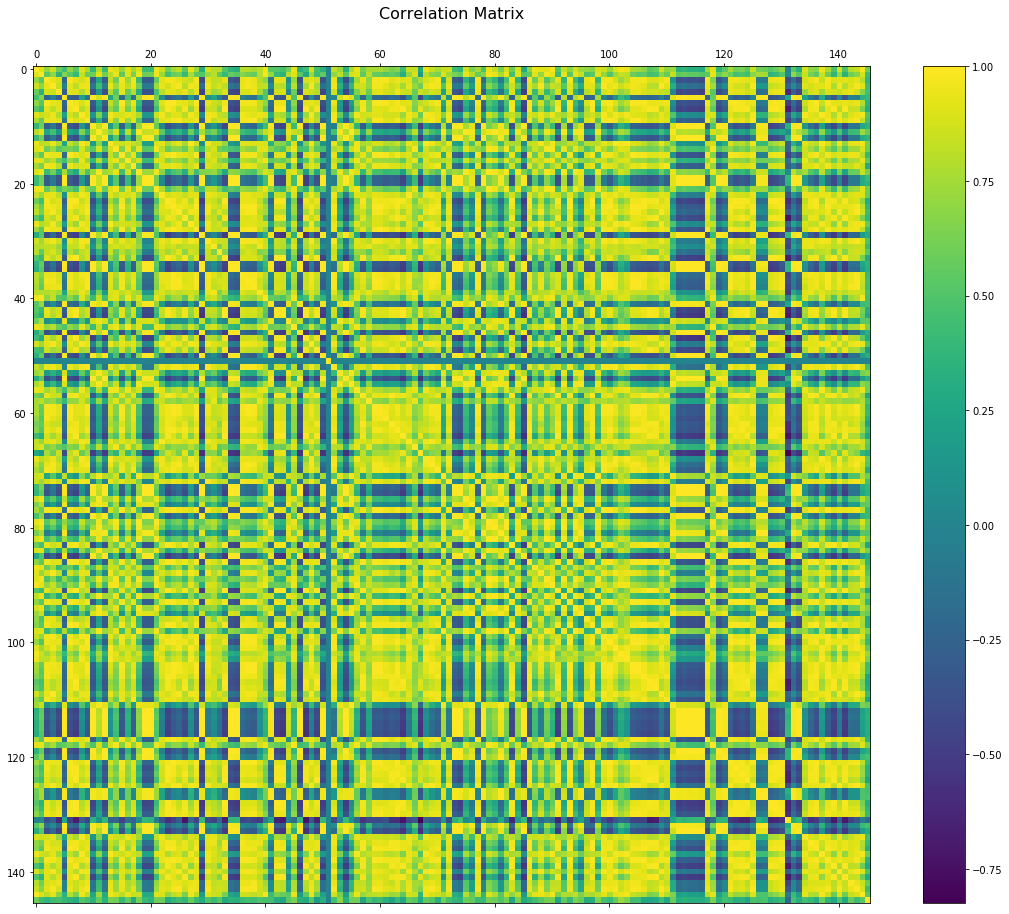

In [60]:
f = plt.figure(figsize=(19, 15))
plt.matshow(pivoted_GDP_df.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix', fontsize=16);

We then try to clusterize this correlation matrix in order to find countries whose GDP are correlated:

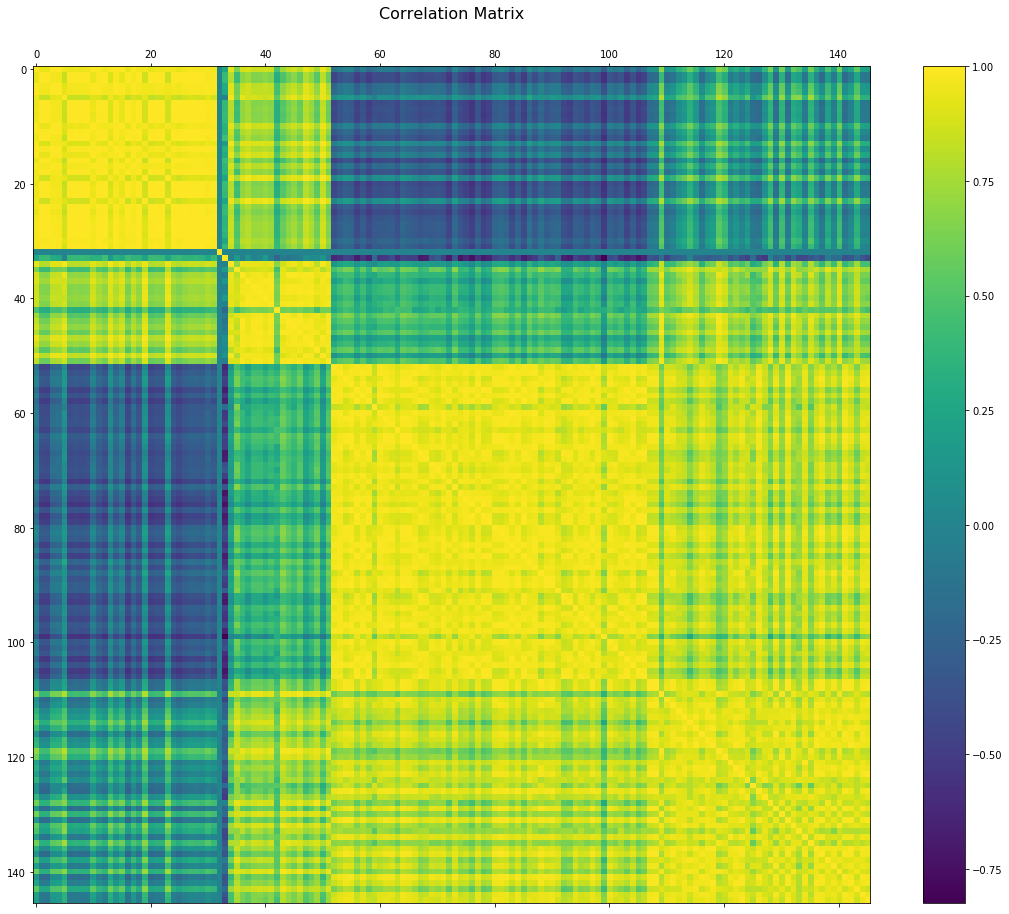

In [61]:
corr = pivoted_GDP_df.corr().values
pdist = spc.distance.pdist(corr)   # vector of ('55' choose 2) pairwise distances
linkage = spc.linkage(pdist, method='complete')
ind = spc.fcluster(linkage, 0.5*pdist.max(), 'distance')
columns = [pivoted_GDP_df.columns.tolist()[i] for i in list((np.argsort(ind)))]
clusterised_df = pivoted_GDP_df.reindex(columns, axis=1)

f = plt.figure(figsize=(19, 15))
plt.matshow(clusterised_df.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix', fontsize=16);

We have found 4 regions in which the GDP is highly correlated and between which the correlation coefficent is lower. We could refine the big clusters by iterating this method.

**Interpretation:** The correlation matrix of GDP contains lots of values that are very closed to one. This means that GDP in two different countries have a trend to evolve the same way. Therefore, we can say that the world countries have strong enough trading relations to make the GDP evolve the same way. The fact that we have found some main clusters could be interpreted as regions in which the trading relations are more important.

#### 2.D. Economic classification of countries <a name="2D"></a>

In [62]:
plot = uni_df[['Area','Year']]
plot["Value"] = uni_df["(GDP, million $)"]
for year in range(1980, 2015, 5):
    display(year, visualise_world_data_folium(plot, year, True))

1980

1985

1990

1995

2000

2005

2010

### 3. Descriptive data analysis  <a name="3"></a>

3. 

    1. [Production and consumption of food from a time-space geography point of view](#3A)
        
        1. [Net food exporters or importers](#3Aa)
        
        2. [Evolution over the last few decades](#3Ab)

    1. [Food self-sufficiency](#3B)

    2. [Analysis of food production and trade with GDP](#3C)
        
        1. [Correlation between production features and GDP](#3Ca)
        
        2. [Correlation between food trade features and GDP](#3Cb)
        
        3. [Machine learning model](#3Cc)  
        
            1. [Model - based on trade](#3Cci)  
        
            2. [Model - based on production](#3Ccii) 

    3. [Food prices stability and agricultural features](#3C)  
  

#### 3.A. Production and consumption of food from a time-space geography point of view <a name="3A"></a>

#### 3.B. Food self-sufficiency <a name="3B"></a>

#### 3.C. Analysis of food production and trade with GDP <a name="3C"></a>

##### 3.C.a. Food production and GDP <a name="3Ca"></a>

Out of the crops and the livestock produced, we will focus on the top 20 crops as well as top 20 livestock produced globally to be able to have a model with a reasonable amount of feautures. 

In [63]:
#Choose the top 20 crops produced in the world for the first model
crop_production_df= uni_df.filter(like='Crops Production tonnes') 
crop_production_df = crop_production_df.sum(axis=0).sort_values(ascending=False)
crop_production_list = crop_production_df.index.tolist()[:20]
crop_production_list.insert(0,'(GDP, million $)')
crop_production_list
#Take the top 20 crops and the columns of our uni_df which contain their production
maincrops_df = uni_df[crop_production_list]

#Livestock
livestock_production_df= uni_df.filter(like='Livestock production') 
livestock_production_df = livestock_production_df.sum(axis=0).sort_values(ascending=False)
livestock_production_list = livestock_production_df.index.tolist()[:20]
livestock_production_list.insert(0,'(GDP, million $)')
livestock_production_list
#Take the top 20 crops and the columns of our uni_df which contain their production
mainlivestock_df = uni_df[livestock_production_list]

top_production_list = crop_production_list +livestock_production_list[1:]

top_production_df = uni_df[top_production_list]
top_production_df.head(5)

(GDP, million $)  Cereals (Rice Milled Eqv) Crops Production tonnes  \
0       1748.886597                                          3390122.0   
1       1831.108982                                          3202450.0   
2       1595.555482                                          3816800.0   
3       1733.333275                                          4130140.0   
4       2155.555500                                          4211140.0   

   Sugar cane Crops Production tonnes  \
0                             55000.0   
1                             50000.0   
2                             35000.0   
3                             58000.0   
4                             51600.0   

   Roots and Tubers,Total Crops Production tonnes  \
0                                        144000.0   
1                                        167000.0   
2                                        158000.0   
3                                        165000.0   
4                                        182000.0   

   Vegetables&Melons, Total Crops Production tonnes  \
0                                          482000.0   
1                                          558000.0   
2                                          500000.0   
3                                          515000.0   
4                                          518000.0   

   Wheat Crops Production tonnes  Rice, paddy Crops Production tonnes  \
0                      2081000.0                             366000.0   
1                      1915000.0                             350000.0   
2                      2450000.0                             400000.0   
3                      2700000.0                             420000.0   
4                      2750000.0                             420000.0   

   Maize Crops Production tonnes  \
0                       667000.0   
1                       670000.0   
2                       720000.0   
3                       760000.0   
4                       770000.0   

   Fruit excl Melons,Total Crops Production tonnes  \
0                                         794600.0   
1                                         634800.0   
2                                         781400.0   
3                                         822500.0   
4                                         847500.0   

   Sugar beet Crops Production tonnes  ...  Asses Livestock production Head  \
0                             62000.0  ...                        1300000.0   
1                             60000.0  ...                        1300000.0   
2                             63300.0  ...                        1300000.0   
3                             57000.0  ...                        1250000.0   
4                             66600.0  ...                        1250000.0   

   Camels Livestock production Head  \
0                          300000.0   
1                          300000.0   
2                          300000.0   
3                          300000.0   
4                          300000.0   

   Animals live nes Livestock production Head  \
0                                    532303.0   
1                                    532303.0   
2                                    532303.0   
3                                    532303.0   
4                                    532303.0   

   Mules Livestock production Head  \
0                          35000.0   
1                          35000.0   
2                          31000.0   
3                          26500.0   
4                          26500.0   

   Poultry Birds Livestock production 1000 Head  \
0                                        6000.0   
1                                        6000.0   
2                                        6000.0   
3                                        6100.0   
4                                        6100.0   

   Chickens Livestock production 1000 Head  \
0                                   6000.0   
1                                   6000.0   
2

In [64]:
#Checking correlations of main crops between each other and with GDP
mainprod_correlation_matrix = round (top_production_df.corr(method='pearson'),3)
mainprod_correlation_matrix['(GDP, million $)'].sort_values(ascending = False)



(GDP, million $)                                         1.000
Maize Crops Production tonnes                            0.837
Tomatoes Crops Production tonnes                         0.833
Chickens Livestock production 1000 Head                  0.832
Poultry Birds Livestock production 1000 Head             0.828
Citrus Fruit,Total Crops Production tonnes               0.806
Cereals (Rice Milled Eqv) Crops Production tonnes        0.797
Fruit excl Melons,Total Crops Production tonnes          0.792
Wheat Crops Production tonnes                            0.777
Soybeans Crops Production tonnes                         0.754
Vegetables&Melons, Total Crops Production tonnes         0.742
Turkeys Livestock production 1000 Head                   0.741
Bananas Crops Production tonnes                          0.700
Pigs Livestock production Head                           0.697
Sugar cane Crops Production tonnes                       0.689
Rabbits and hares Livestock production 1000 Head       

Because "Cereals (Rice Milled Eqv) Crops Production tonnes" has such a high correlation with a lot of other features, it is probably an aggregate of them (eg over 90% with wheat).

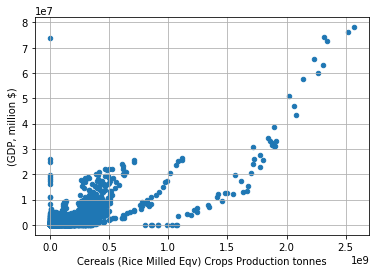

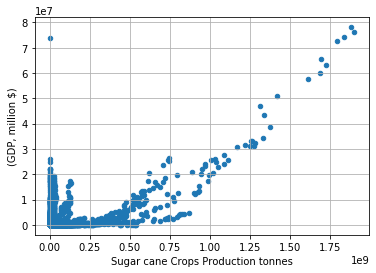

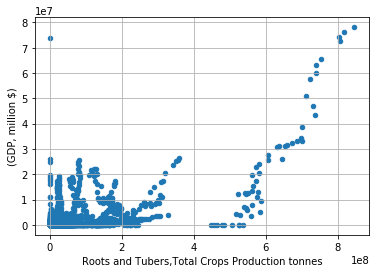

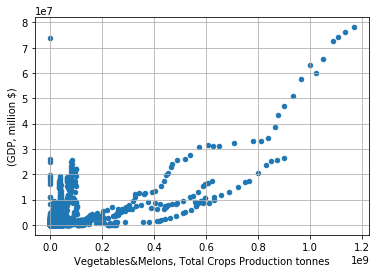

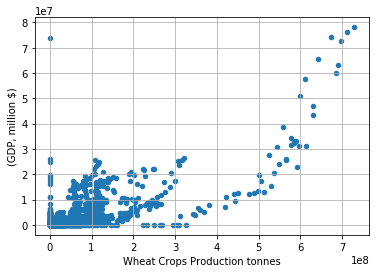

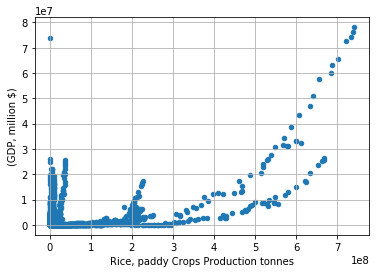

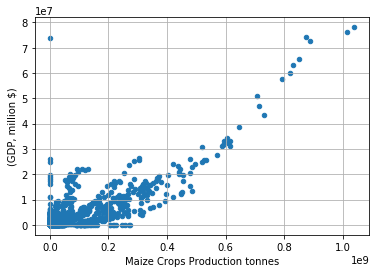

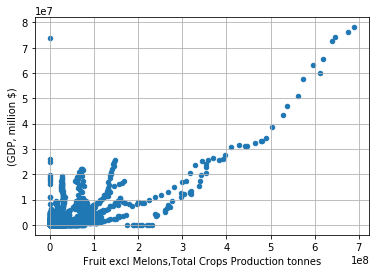

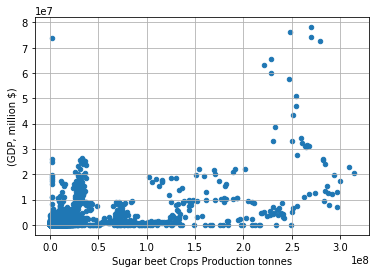

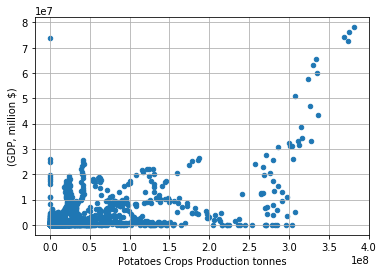

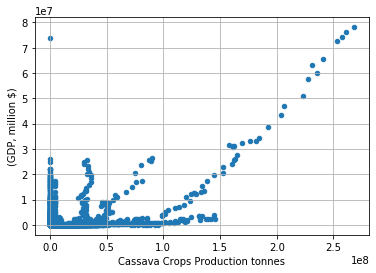

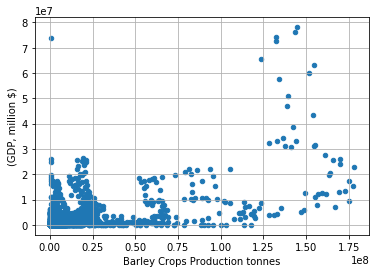

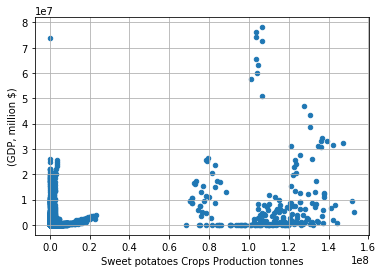

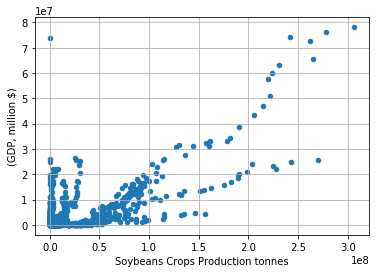

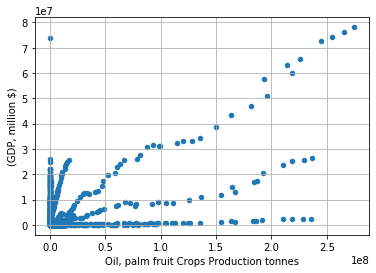

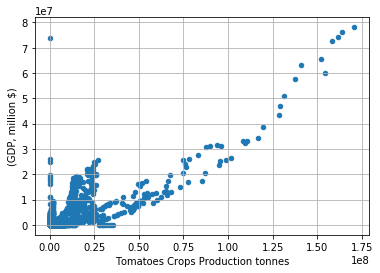

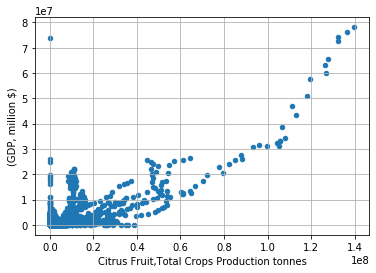

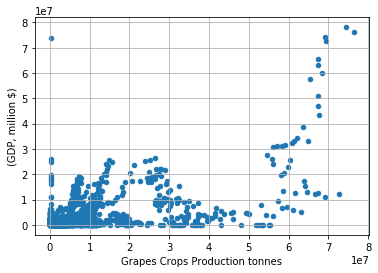

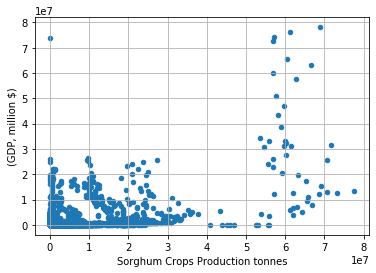

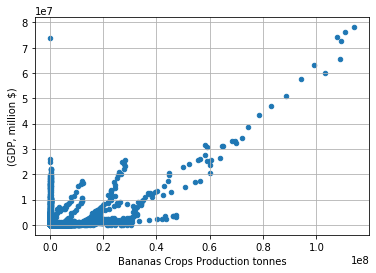

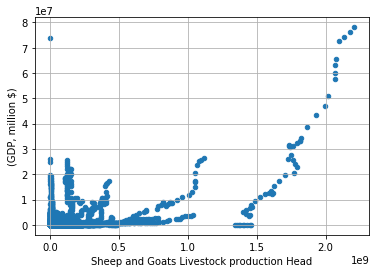

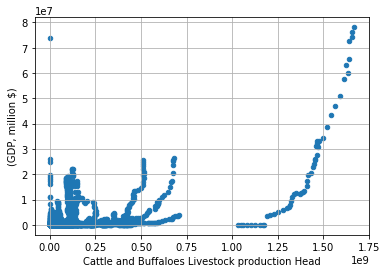

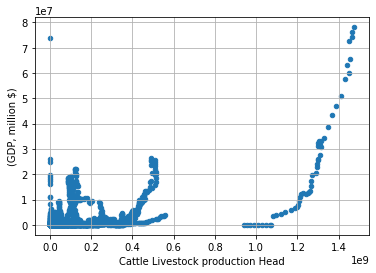

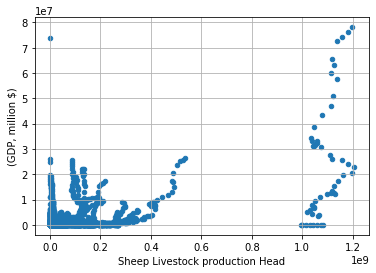

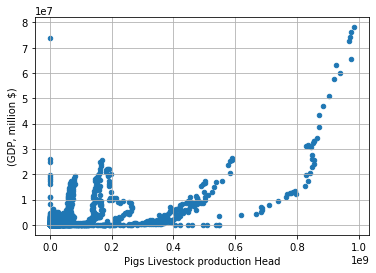

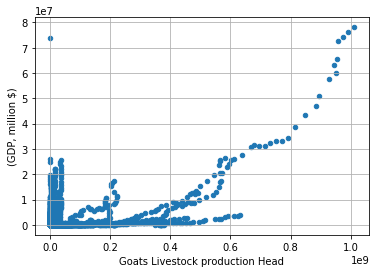

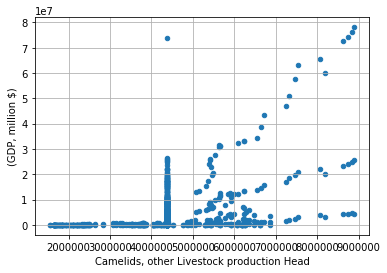

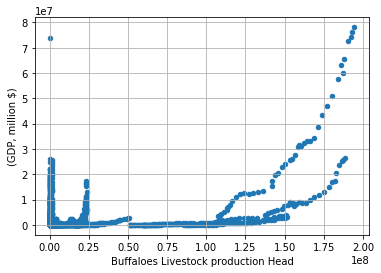

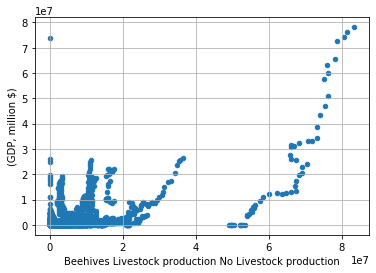

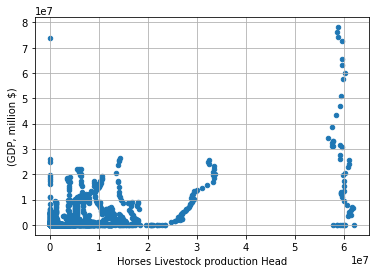

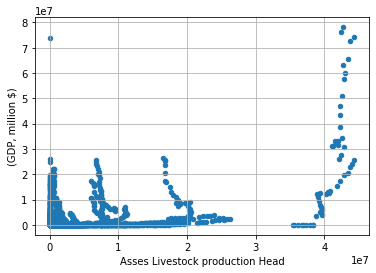

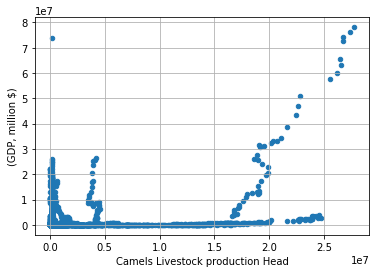

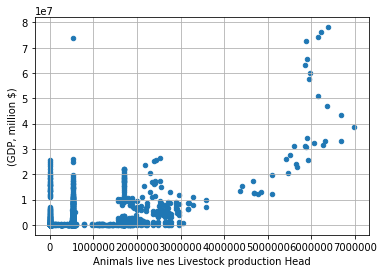

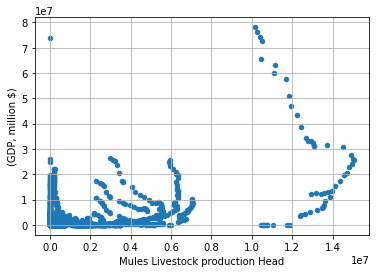

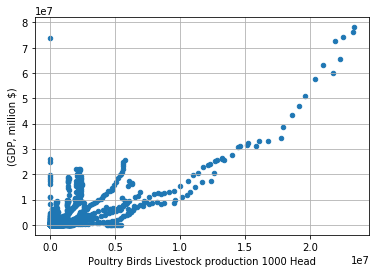

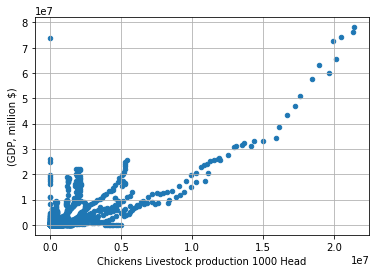

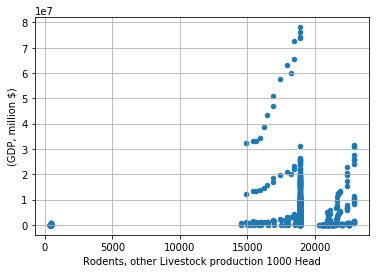

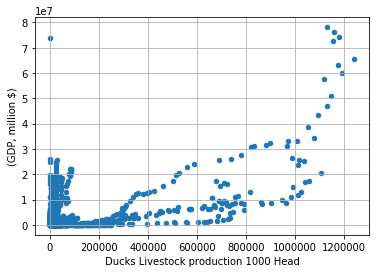

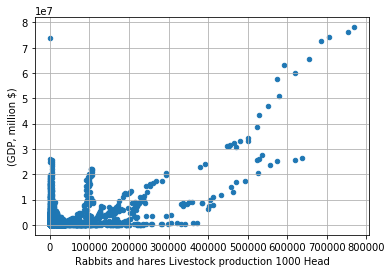

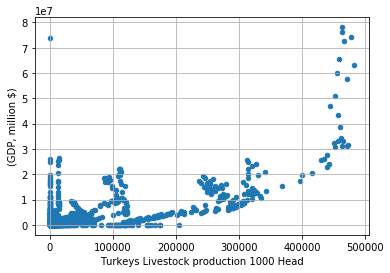

In [65]:
#Looking at some relationships
for item in list(top_production_df.columns)[1:]:
    top_production_df.plot(kind='scatter', x=item, y='(GDP, million $)', grid=True)


We can quite clearly see that the production of many of the most popular crops can well be related to GDP.

##### 3.C.b. Trade and GDP <a name="3Cb"></a>

Let's see if the same can be said about the most exported/imported goods.

In [66]:
#Choose the top 20 most exported items by mass
top_exports_df= uni_df.filter(like='export quantities tonnes')
top_exports_df = top_exports_df.sum(axis=0).sort_values(ascending=False)
top_exports_list =top_exports_df.index.tolist()[:20]
top_exports_list

#Take the top 20 exported crops and the columns of our uni_df which contain their production
top_exports_list.insert(0,'(GDP, million $)')
top_exports_df = uni_df[top_exports_list]


#Choose the top 20 most imported items by mass
top_imports_df= uni_df.filter(like='import quantities tonnes')
top_imports_df = top_imports_df.sum(axis=0).sort_values(ascending=False)

top_imports_list =top_imports_df.index.tolist()[:20]
top_imports_list

#Take the top 20 imported items and the columns of our uni_df which contain their production
top_imports_list.insert(0,'(GDP, million $)')
top_imports_df = uni_df[top_imports_list]

#Create a joined list
top_traded_list = top_exports_list +top_imports_list[1:]

In [67]:

top_traded_df = uni_df[top_traded_list]
top_traded_df.head(5)

(GDP, million $)  Cereals Food export quantities tonnes  \
0       1748.886597                                20000.0   
1       1831.108982                                20000.0   
2       1595.555482                                20000.0   
3       1733.333275                                20000.0   
4       2155.555500                                20000.0   

   Wheat+Flour,Wheat Equivalent Food export quantities tonnes  \
0                                             2511.0            
1                                             2511.0            
2                                             2511.0            
3                                             2511.0            
4                                             2511.0            

   Wheat Food export quantities tonnes  \
0                                623.0   
1                                623.0   
2                                623.0   
3                                623.0   
4                                623.0   

   Fodder & Feeding stuff Food export quantities tonnes  \
0                                                0.0      
1                                                0.0      
2                                                0.0      
3                                                0.0      
4                                                0.0      

   Maize Food export quantities tonnes  \
0                                900.0   
1                                900.0   
2                                900.0   
3                                900.0   
4                                900.0   

   Milk Equivalent Food export quantities tonnes  \
0                                         3617.5   
1                                         3617.5   
2                                         3617.5   
3                                         3617.5   
4                                         3617.5   

   Sugar and Honey Food export quantities tonnes  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   Oilseeds Food export quantities tonnes  \
0                                  7229.0   
1                                  3456.0   
2                                 34541.0   
3                                 27678.0   
4                                 18490.0   

   Oilseed Cake Meal Food export quantities tonnes  ...  \
0                                              0.0  ...   
1                                              0.0  ...   
2                                              0.0  ...   
3                                              0.0  ...   
4                                              0.0  ...   

   Cake, soybeans Food import quantities tonnes  \
0                                       19731.0   
1                                       19731.0   
2                                       19731.0   
3                                       19731.0   
4                                       19731.0   

   Animal Vegetable Oil Food import quantities tonnes  \
0                                             8286.0    
1                                            11763.0    
2                                            14471.0    
3                                            10279.0    
4                                            11017.0    

   Sugar,Total (Raw Equiv.) Food import quantities tonnes  \
0                                            57611.0        
1                                            49413.0        
2                                            46332.0        
3                                            60959.0        
4                                            54024.0        

   Beverages Food import quantities tonnes  \
0                                     12.0   
1                

In [68]:
#Checking correlations of main traded goods between each other and with GDP
top_traded_correlation_matrix = round (top_traded_df.corr(method='pearson'),3)
top_traded_correlation_matrix['(GDP, million $)'].sort_values(ascending = False)


(GDP, million $)                                                        1.000
Total Meat Food export quantities tonnes                                0.827
Fodder & Feeding stuff Food export quantities tonnes                    0.823
Animal Vegetable Oil Food import quantities tonnes                      0.806
Fixed Vegetable Oils Food import quantities tonnes                      0.797
Milk Equivalent Food import quantities tonnes                           0.779
Sugar and Honey Food import quantities tonnes                           0.768
Cereals Food export quantities tonnes                                   0.759
Animal Vegetable Oil Food export quantities tonnes                      0.758
Oilseed Cake Meal Food export quantities tonnes                         0.758
Beverages Food import quantities tonnes                                 0.755
Oilseeds Food export quantities tonnes                                  0.749
Sugar,Total (Raw Equiv.) Food import quantities tonnes          

It seems that the most high correlations can be found from  exports of meat as well as feeding stuff. 

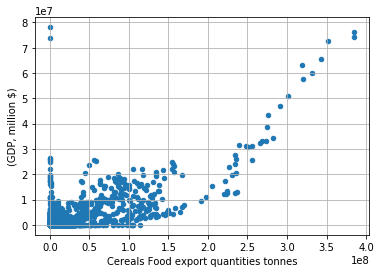

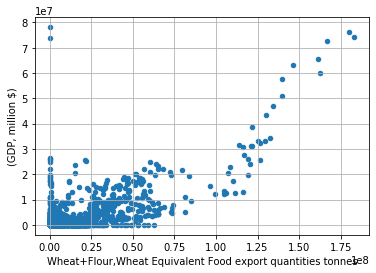

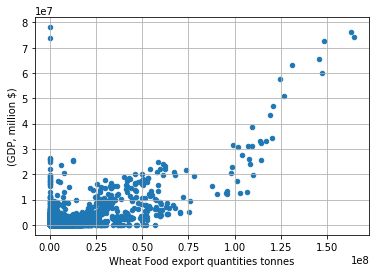

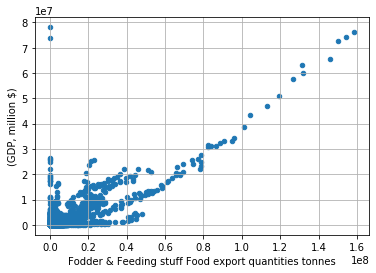

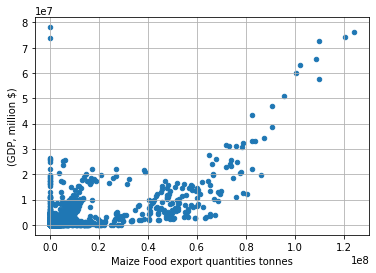

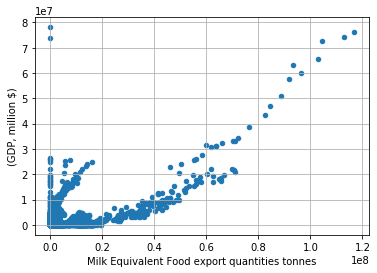

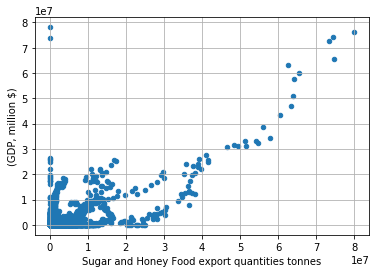

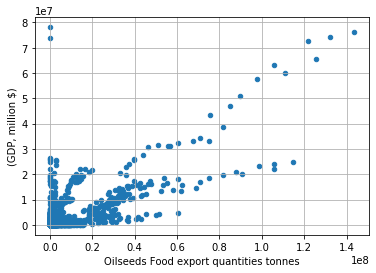

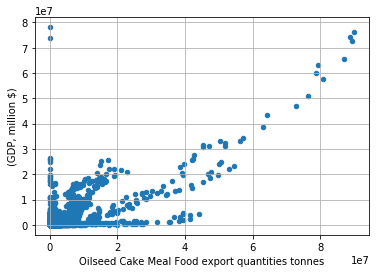

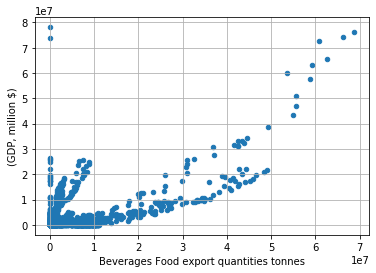

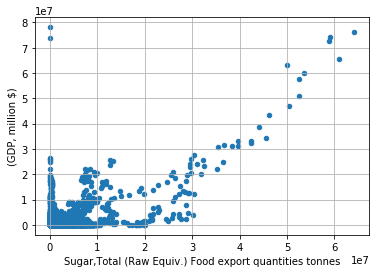

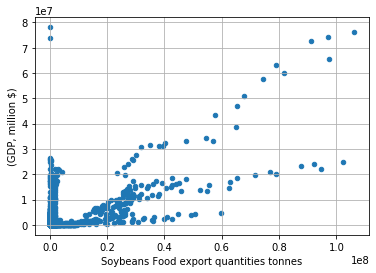

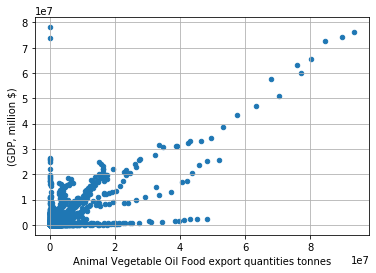

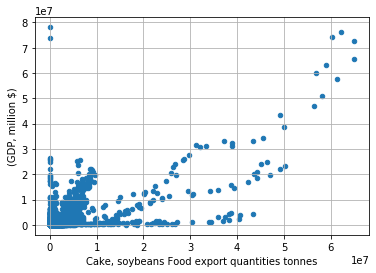

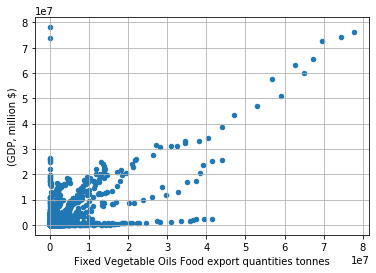

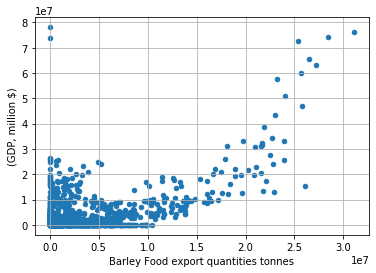

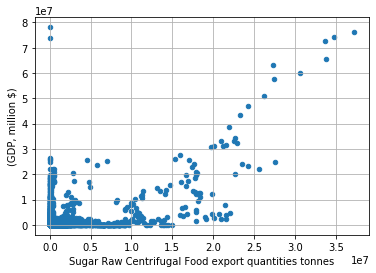

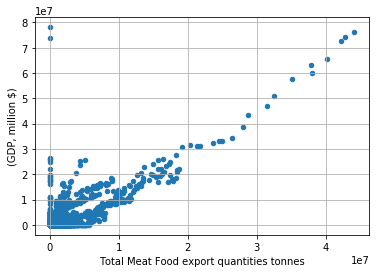

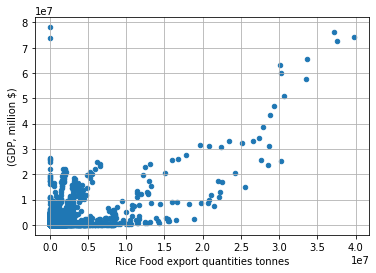

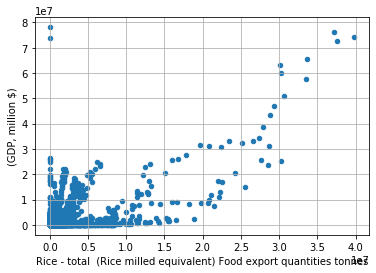

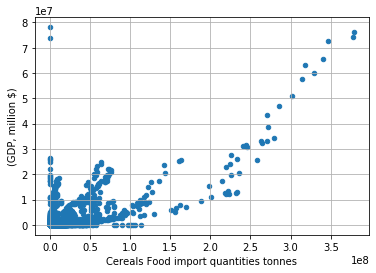

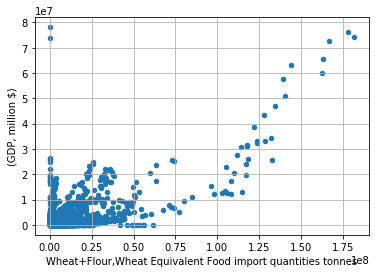

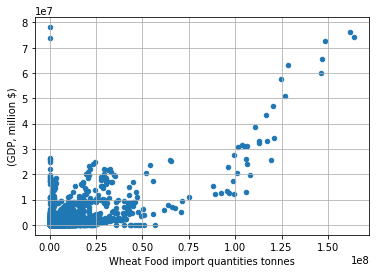

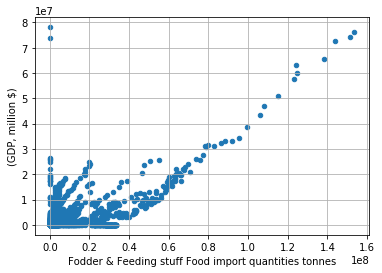

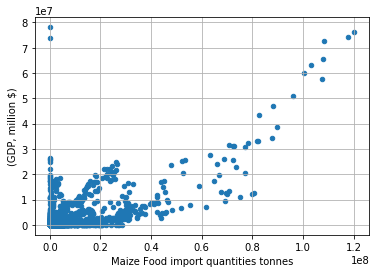

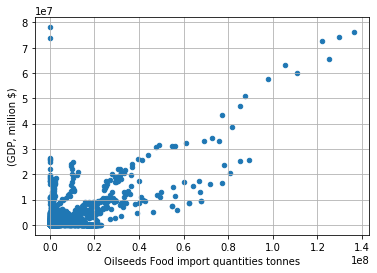

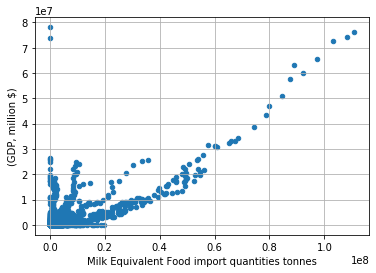

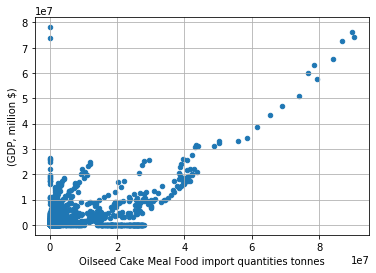

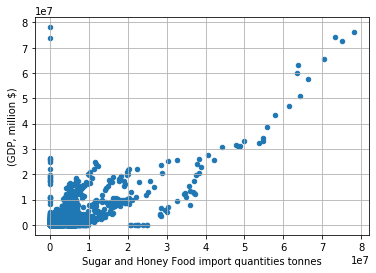

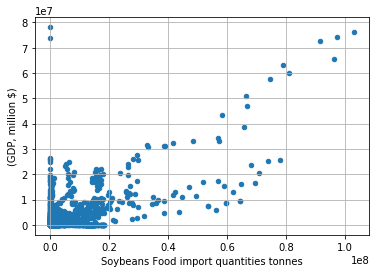

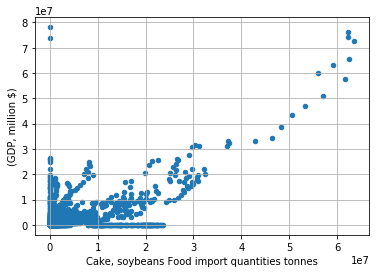

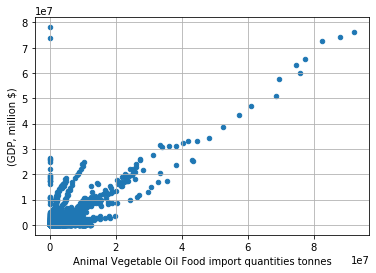

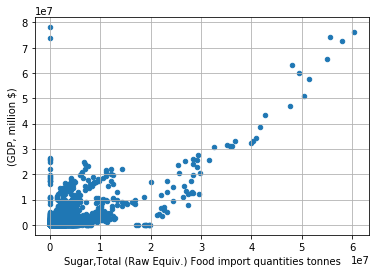

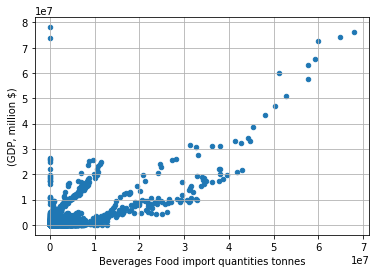

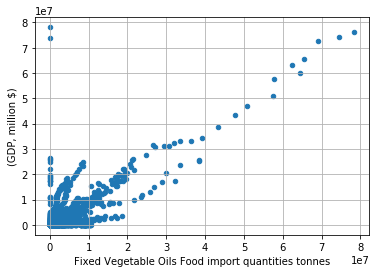

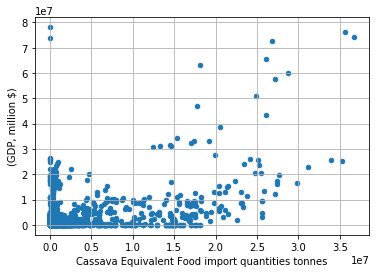

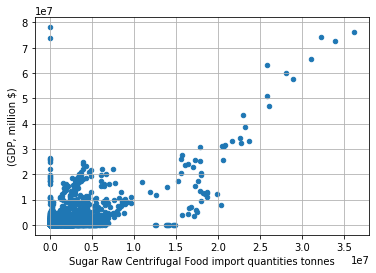

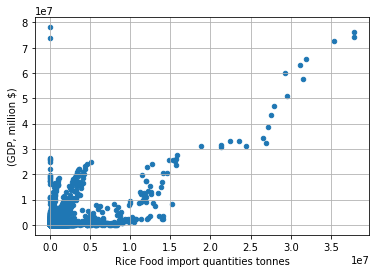

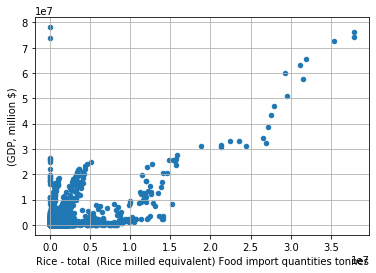

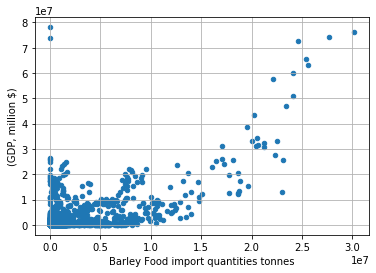

In [69]:
#Looking at some relationships
for item in list(top_traded_df.columns)[1:]:
    top_traded_df.plot(kind='scatter', x=item, y='(GDP, million $)', grid=True)


##### 3.C.c. Machine learning model <a name="3Cc"></a>

###### 3.C.c.i. Model - based on production <a name="3Cci"></a>

First, we only create a model using the production data. Afterwards, we use the data on exports, imports. 

#### Standardization, scaling


Clearly seeing that our data isn't normally distributed, this means we shouldn't use standardization. We'll use a min-max scaling to make different quantities comparable in the same model. 

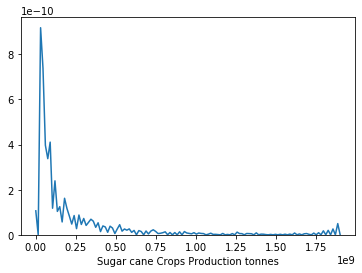

In [70]:
sns.distplot(maincrops_df["Sugar cane Crops Production tonnes"], rug=False, hist=False)

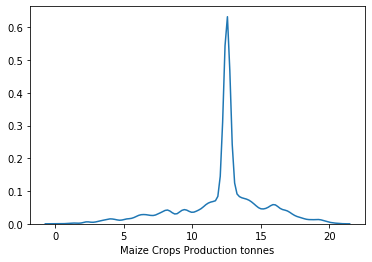

In [71]:
sns.distplot(np.log(maincrops_df["Maize Crops Production tonnes"]), rug=False, hist=False)

We can clearly see that the production is not normally distributed, thus we shouldn't use a normalization of our features.
The huge peak is probably from all the Nan values we set to the median...

In [72]:
#With MINMAX and not standardization, because it isn't a normal distribution.
top_production_values = top_production_df.values
min_max_scaler = preprocessing.MinMaxScaler()
top_production_minmaxed_values = min_max_scaler.fit_transform(top_production_values)
top_production_minmaxed = pd.DataFrame(top_production_minmaxed_values, columns=top_production_df.columns)
top_production_minmaxed.head(5)

(GDP, million $)  Cereals (Rice Milled Eqv) Crops Production tonnes  \
0          0.000022                                           0.001318   
1          0.000023                                           0.001245   
2          0.000020                                           0.001484   
3          0.000022                                           0.001606   
4          0.000028                                           0.001638   

   Sugar cane Crops Production tonnes  \
0                            0.000029   
1                            0.000026   
2                            0.000018   
3                            0.000030   
4                            0.000027   

   Roots and Tubers,Total Crops Production tonnes  \
0                                        0.000170   
1                                        0.000198   
2                                        0.000187   
3                                        0.000195   
4                                        0.000215   

   Vegetables&Melons, Total Crops Production tonnes  \
0                                          0.000412   
1                                          0.000477   
2                                          0.000428   
3                                          0.000440   
4                                          0.000443   

   Wheat Crops Production tonnes  Rice, paddy Crops Production tonnes  \
0                       0.002855                             0.000494   
1                       0.002627                             0.000472   
2                       0.003361                             0.000539   
3                       0.003704                             0.000566   
4                       0.003772                             0.000566   

   Maize Crops Production tonnes  \
0                       0.000643   
1                       0.000646   
2                       0.000694   
3                       0.000732   
4                       0.000742   

   Fruit excl Melons,Total Crops Production tonnes  \
0                                         0.001153   
1                                         0.000921   
2                                         0.001133   
3                                         0.001193   
4                                         0.001229   

   Sugar beet Crops Production tonnes  ...  Asses Livestock production Head  \
0                            0.000197  ...                         0.029312   
1                            0.000191  ...                         0.029312   
2                            0.000201  ...                         0.029312   
3                            0.000181  ...                         0.028185   
4                            0.000212  ...                         0.028185   

   Camels Livestock production Head  \
0                          0.010816   
1                          0.010816   
2                          0.010816   
3                          0.010816   
4                          0.010816   

   Animals live nes Livestock production Head  \
0                                    0.076211   
1                                    0.076211   
2                                    0.076211   
3                                    0.076211   
4                                    0.076211   

   Mules Livestock production Head  \
0                         0.002322   
1                         0.002322   
2                         0.002057   
3                         0.001758   
4                         0.001758   

   Poultry Birds Livestock production 1000 Head  \
0                                      0.000257   
1                                      0.000257   
2                                      0.000257   
3                                      0.000261   
4                                      0.000261   

   Chickens Livestock production 1000 Head  \
0                                 0.000280   
1                                 0.000280   
2

In [73]:
train_set, test_set = train_test_split(top_production_minmaxed.values, test_size = 0.2, random_state = 1)

X_train_set = train_set[:,1:]
Y_train_set = train_set[:,0]

X_test_set = test_set[:,1:]
Y_test_set = test_set[:,0]

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:27<00:00, 14.30it/s]


The best value obtained is for alpha equal to 0.0 with a MSE of 0.00018993972148451834


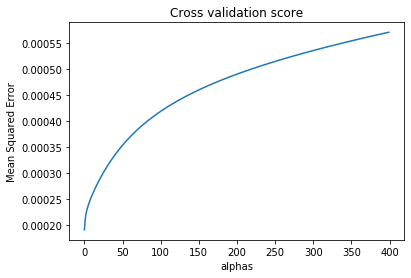

In [74]:
number_of_folds = 5
scores = []
list_of_alpha = [i for i in np.arange(0,400,1)]
for alpha in tqdm(list_of_alpha):
    clf = Ridge(alpha = alpha)
    score = cross_val_score(clf, X_train_set, Y_train_set, cv=number_of_folds, scoring = 'neg_mean_squared_error')
    scores.append([alpha, score.mean()])
a=np.array(scores)
print("The best value obtained is for alpha equal to " + str(a[np.where(a==np.amax(a[:,1]))[0]][0,0]) + " with a MSE of "+ str(-a[np.where(a==np.amax(a[:,1]))[0]][0,1]))
alphas = [elt[0] for elt in scores]
MSE = [-elt[1] for elt in scores]
sns.lineplot(alphas, MSE)
_ = plt.title("Cross validation score")
_ = plt.ylabel("Mean Squared Error")
_ = plt.xlabel("alphas")

In [75]:
#this means I choose my alpha as 0??
# We build our model with the chosen alpha.
model_top_production = Ridge(alpha=0)
model_top_production.fit(X_train_set, Y_train_set)



Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [76]:
weights_top_production = pd.DataFrame([model_top_production.coef_], columns=top_production_df.columns[1:])
weights_top_production = weights_top_production.sort_values(by=0, axis=1, ascending=False)                                  
weights_top_production

Chickens Livestock production 1000 Head  \
0                                 6.968226   

   Cereals (Rice Milled Eqv) Crops Production tonnes  \
0                                           1.049415   

   Fruit excl Melons,Total Crops Production tonnes  \
0                                         0.778406   

   Cattle Livestock production Head  \
0                          0.530833   

   Roots and Tubers,Total Crops Production tonnes  \
0                                        0.380118   

   Ducks Livestock production 1000 Head  Sugar beet Crops Production tonnes  \
0                              0.236095                            0.221196   

   Vegetables&Melons, Total Crops Production tonnes  \
0                                          0.198248   

   Buffaloes Livestock production Head  \
0                             0.150289   

   Sheep and Goats Livestock production Head  ...  \
0                                   0.119379  ...   

   Grapes Crops Production tonnes  Barley Crops Production tonnes  \
0                       -0.127099                       -0.133032   

   Citrus Fruit,Total Crops Production tonnes  \
0                                   -0.137365   

   Bananas Crops Production tonnes  Cassava Crops Production tonnes  \
0                        -0.168986                        -0.171376   

   Sorghum Crops Production tonnes  Rice, paddy Crops Production tonnes  \
0                        -0.270677                            -0.348605   

   Potatoes Crops Production tonnes  \
0                          -0.55206   

   Cattle and Buffaloes Livestock production Head  \
0                                       -0.786411   

   Poultry Birds Livestock production 1000 Head  
0                                     -7.247204  

[1 rows x 40 columns]

In [77]:
model_top_production.score(X_train_set, Y_train_set)

0.8402735698901358

The result doesn't seem to make sense!! probably because chickens and poultry are so highly correlated. 

###### 3.C.c.ii. Model - based on trade <a name="3Ccii"></a>

In [78]:
#With MINMAX and not standardization, because it isn't a normal distribution.
top_traded_values = top_traded_df.values
min_max_scaler = preprocessing.MinMaxScaler()
top_traded_minmaxed_values = min_max_scaler.fit_transform(top_traded_values)
top_traded_minmaxed = pd.DataFrame(top_traded_minmaxed_values, columns=top_traded_df.columns)
top_traded_minmaxed.head(5)

(GDP, million $)  Cereals Food export quantities tonnes  \
0          0.000022                               0.000052   
1          0.000023                               0.000052   
2          0.000020                               0.000052   
3          0.000022                               0.000052   
4          0.000028                               0.000052   

   Wheat+Flour,Wheat Equivalent Food export quantities tonnes  \
0                                           0.000014            
1                                           0.000014            
2                                           0.000014            
3                                           0.000014            
4                                           0.000014            

   Wheat Food export quantities tonnes  \
0                             0.000004   
1                             0.000004   
2                             0.000004   
3                             0.000004   
4                             0.000004   

   Fodder & Feeding stuff Food export quantities tonnes  \
0                                                0.0      
1                                                0.0      
2                                                0.0      
3                                                0.0      
4                                                0.0      

   Maize Food export quantities tonnes  \
0                             0.000007   
1                             0.000007   
2                             0.000007   
3                             0.000007   
4                             0.000007   

   Milk Equivalent Food export quantities tonnes  \
0                                       0.000031   
1                                       0.000031   
2                                       0.000031   
3                                       0.000031   
4                                       0.000031   

   Sugar and Honey Food export quantities tonnes  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   Oilseeds Food export quantities tonnes  \
0                                0.000050   
1                                0.000024   
2                                0.000241   
3                                0.000193   
4                                0.000129   

   Oilseed Cake Meal Food export quantities tonnes  ...  \
0                                              0.0  ...   
1                                              0.0  ...   
2                                              0.0  ...   
3                                              0.0  ...   
4                                              0.0  ...   

   Cake, soybeans Food import quantities tonnes  \
0                                       0.00031   
1                                       0.00031   
2                                       0.00031   
3                                       0.00031   
4                                       0.00031   

   Animal Vegetable Oil Food import quantities tonnes  \
0                                           0.000090    
1                                           0.000127    
2                                           0.000157    
3                                           0.000111    
4                                           0.000119    

   Sugar,Total (Raw Equiv.) Food import quantities tonnes  \
0                                           0.000954        
1                                           0.000818        
2                                           0.000767        
3                                           0.001009        
4                                           0.000894        

   Beverages Food import quantities tonnes  \
0                             1.764093e-07   
1                

In [79]:
train_set, test_set = train_test_split(top_traded_minmaxed.values, test_size = 0.2, random_state = 1)

X_train_set = train_set[:,1:]
Y_train_set = train_set[:,0]

X_test_set = test_set[:,1:]
Y_test_set = test_set[:,0]

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:29<00:00, 13.67it/s]


The best value obtained is for alpha equal to 0.0 with a MSE of 0.00026671001602442595


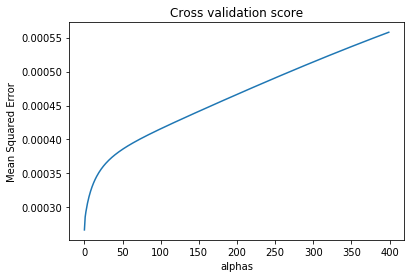

In [80]:
number_of_folds = 5
scores = []
list_of_alpha = [i for i in np.arange(0,400,1)]
for alpha in tqdm(list_of_alpha):
    clf = Ridge(alpha = alpha)
    score = cross_val_score(clf, X_train_set, Y_train_set, cv=number_of_folds, scoring = 'neg_mean_squared_error')
    scores.append([alpha, score.mean()])
a=np.array(scores)
print("The best value obtained is for alpha equal to " + str(a[np.where(a==np.amax(a[:,1]))[0]][0,0]) + " with a MSE of "+ str(-a[np.where(a==np.amax(a[:,1]))[0]][0,1]))
alphas = [elt[0] for elt in scores]
MSE = [-elt[1] for elt in scores]
sns.lineplot(alphas, MSE)
_ = plt.title("Cross validation score")
_ = plt.ylabel("Mean Squared Error")
_ = plt.xlabel("alphas")

In [81]:
# We build our model with the chosen alpha.
model_trade = Ridge(alpha=0)
model_trade.fit(X_train_set, Y_train_set)



Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [82]:
weights_trade = pd.DataFrame([model_trade.coef_], columns=top_traded_minmaxed.columns[1:])
weights_trade = weights_trade.sort_values(by=0, axis=1, ascending=False)                                  
weights_trade

Rice - total  (Rice milled equivalent) Food export quantities tonnes  \
0                                            3.04501                      

   Fodder & Feeding stuff Food import quantities tonnes  \
0                                           1.034067      

   Fodder & Feeding stuff Food export quantities tonnes  \
0                                           0.776319      

   Rice - total  (Rice milled equivalent) Food import quantities tonnes  \
0                                           0.537593                      

   Fixed Vegetable Oils Food import quantities tonnes  \
0                                           0.433523    

   Maize Food export quantities tonnes  \
0                             0.411777   

   Fixed Vegetable Oils Food export quantities tonnes  \
0                                           0.399938    

   Soybeans Food import quantities tonnes  \
0                                0.396629   

   Wheat Food export quantities tonnes  \
0                             0.382785   

   Total Meat Food export quantities tonnes  ...  \
0                                   0.32971  ...   

   Wheat Food import quantities tonnes  \
0                             -0.12249   

   Animal Vegetable Oil Food import quantities tonnes  \
0                                          -0.142197    

   Milk Equivalent Food export quantities tonnes  \
0                                      -0.149117   

   Oilseeds Food import quantities tonnes  \
0                               -0.382451   

   Animal Vegetable Oil Food export quantities tonnes  \
0                                            -0.3866    

   Oilseed Cake Meal Food export quantities tonnes  \
0                                        -0.390715   

   Rice Food import quantities tonnes  \
0                           -0.581538   

   Oilseed Cake Meal Food import quantities tonnes  \
0                                         -1.10162   

   Cereals Food export quantities tonnes  Rice Food export quantities tonnes  
0                              -1.149509                            -2.92374  

[1 rows x 40 columns]

In [83]:
model_trade.score(X_train_set, Y_train_set)

0.7708287882425322

This needs to be cleaned, bc obviously the one with highest and lowest weights are actually super related.

#### 3.D. Food prices stability and agricultural features <a name="3D"></a>

### 4. Informed plan for next actions  <a name="4"></a>

Our results seem pretty intersting to share to the world. Moreover we have nice interactive maps and we would like to focus more on visual and style than writting on methodology. Therefore, we would like to produce a data story.
